# ***Voorspellen van Verhuuraantallen*** 

Teamleden:
- Busse Heemskerk
- Declan van den Hoek
- Isa Dijkstra

In dit notebook worden er, aan de hand van een train dataset, verschillende Machine Learning modellen opgesteld om de meest accurate manier te vinden om diabetes te voorspellen. Voor het project hebben we gewerkt in [GitHub](https://github.com/BJHeemskerk/MachineLearning), om makkelijk de bestanden te delen.

## ***Inhoudsopgave*** <a name='begin'></a>

1. [H1: Explorative Data Analysis](#h1)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_test = pd.read_csv('test.csv', sep = ',')
data_train = pd.read_csv('train.csv', sep = ',')

In [2]:
data_train.head()

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1


## **H1: Explorative Data Analysis**<a name='h1'></a>

De minimale vereisten voor Machine Learning met Scikit Learn zijn:

- De data mag geen missende waardes hebben
- De data moet bestaan uit numerieke waardes
- De data moet in een dataframe staan

Omdat de data is ingelezen via Pandas staat het al in een Pandas DataFrame, hierdoor kan gebruik gemaakt worden van de .info() methode van DataFrames om te kijken naar missende waarden en de datatypen.

In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_hour   16637 non-null  object 
 1   holiday     16637 non-null  int64  
 2   weathersit  16637 non-null  int64  
 3   temp        16637 non-null  float64
 4   atemp       16637 non-null  float64
 5   hum         16637 non-null  float64
 6   windspeed   16637 non-null  float64
 7   cnt         16637 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1.0+ MB


In [4]:
data_train.describe()

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


### ***Time-Series visualisaties***

Eerst zullen er de benodigde functies worden aangemaakt, om op die manier gemakkelijk de verschillende nieuwe time-series kolommen aan te maken.

In [5]:
def seizoen(maand, dag):
    """
    Een functie die op basis van maand en dag de seizoenen
    kan bepalen in een kolom.

    Parameters:
    ----------
    maand : str
        De kolomnaam met de maanden

    dag : str
        De kolomnaam met de dagnummers

    Returns:
    ----------
    int
        Een nummer die correspondeerd met het seizoen
    """

    if (maand == 3 and dag >= 21) or (maand > 3 and maand < 6) or (maand == 6 and dag < 21):
        return 2 # Lente
    elif (maand == 6 and dag >= 21) or (maand > 6 and maand < 9) or (maand == 9 and dag < 21):
        return 3 # Zomer
    elif (maand == 9 and dag >= 21) or (maand > 9 and maand < 12) or (maand == 12 and dag < 21):
        return 4 # Herfst
    else:
        return 1 # Winter

def data_voorbereiding(base_df, dt_kol):
    """
    Een functie om een csv in te lezen en verschillende
    toepassingen uit te voeren op aanwezige timeseries
    data.

    Parameters:
    ----------
    base_df : pd.DataFrame
        De naam van het dataframe waar de extra
        timeseries kolommen worden gemaakt.
    
    dt_kol : str
        De naam van de kolom met de Timeseries data.

    Returns:
    ----------
    df : pd.DataFrame
        Een pandas.DataFrame waarin verschillende extra
        kolommen zijn toegevoegd waarin timeseries is
        toegepast.
    """
    
    # Omzetten van date_hour naar datetime
    df = base_df.copy()
    df[f'{dt_kol}'] = pd.to_datetime(df[f'{dt_kol}'])

    # Voeg nieuwe kolommen toe
    df['Jaar'] = df[f'{dt_kol}'].dt.year
    df['Maand'] = df[f'{dt_kol}'].dt.month
    df['Week'] = df[f'{dt_kol}'].dt.isocalendar().week
    df['Dag'] = df[f'{dt_kol}'].dt.day
    df['Uur'] = df[f'{dt_kol}'].dt.hour
    df['Datum'] = df[f'{dt_kol}'].dt.date

    # Toevoegen seizoenen
    df['Seizoen'] = df.apply(lambda row: seizoen(row['Maand'], row['Dag']), axis=1)

    return df

Deze functies zullen helpen om nieuwe kolommen toe te voegen aan data_train, en later ook aan data_test.

In [6]:
df = data_voorbereiding(data_train, 'date_hour')
df.head()

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,Jaar,Maand,Week,Dag,Uur,Datum,Seizoen
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16,2011,1,52,1,0,2011-01-01,1
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40,2011,1,52,1,1,2011-01-01,1
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32,2011,1,52,1,2,2011-01-01,1
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13,2011,1,52,1,3,2011-01-01,1
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1,2011,1,52,1,4,2011-01-01,1


### ***Time-Series Visualiseren***

Nu wordt er een class gemaakt die het mogelijk maakt om snel en eenvoudig verschillende grafieken aan te maken.

In [7]:
class Grafieken:
    """
    Een class voor eenvoudig visualiseren met Matplotlib
    en seaborn.

    Parameters:
    ----------
    df : pandas.DataFrame
        Een pandas.DataFrame die data bevat om mee te
        visualiseren.
    """

    def __init__(self, df):
        """
        De constructor voor de Grafieken class

        Parameters:
        ----------
        df : pandas.DataFrame
            Een pandas.DataFrame die data bevat om mee te
            visualiseren.
        """
        # Aanmaken self.df
        self.df = df

    def plot_bar(self, x, y, hue=None):
        """
        Een functie om barplots te kunnen maken

        Parameters:
        ----------
        x : str
            De kolom voor de x-as

        y : str
            De kolom voor de y-as

        hue : str, optional (default=None)
            De kolom voor eventuele kleur coderingen binnen
            de grafiek
        """
        # Aanmaken van plotgrootte en barplot
        plt.subplots(figsize=(15, 5))
        sns.barplot(data=self.df, x=x, y=y,
                    errorbar=None, hue=hue,
                    palette='deep')
        
        # Titel en tonen van de grafiek
        plt.title(f'Kolom: {y} t.o.v. Periode: {x}')
        plt.show()

    def plot_box(self, x, y):
        """
        Een functie om boxplots te kunnen maken

        Parameters:
        ----------
        x : str
            De kolom voor de x-as
        
        y : str
            De kolom voor de y-as
        """
        # Aanmaken van plotgrootte en boxplot
        plt.subplots(figsize=(15, 5))
        sns.boxplot(data=self.df, x=x, y=y)

        # Titel en tonen van de grafiek
        plt.title(f'Boxplot voor kolom: {y} t.o.v. Periode: {x}')
        plt.show()

    def plot_outliers(self):
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=df, x='date_hour', y='cnt', hue=(df['cnt'] > df['cnt'].quantile(0.95)))
        plt.title('Scatterplot van cnt met oranje outliers')
        plt.show()


Met behulp van deze class en twee lijsten kan er in een klein aantal cellen worden gevisualiseerd

In [8]:
# Aanroepen class
visulisaties = Grafieken(df)

# Aanmaken lijsten voor loops
tijden = ['Jaar', 'Seizoen', 'Maand', 'Week', 'Dag', 'Uur']
kolommen = ['holiday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']

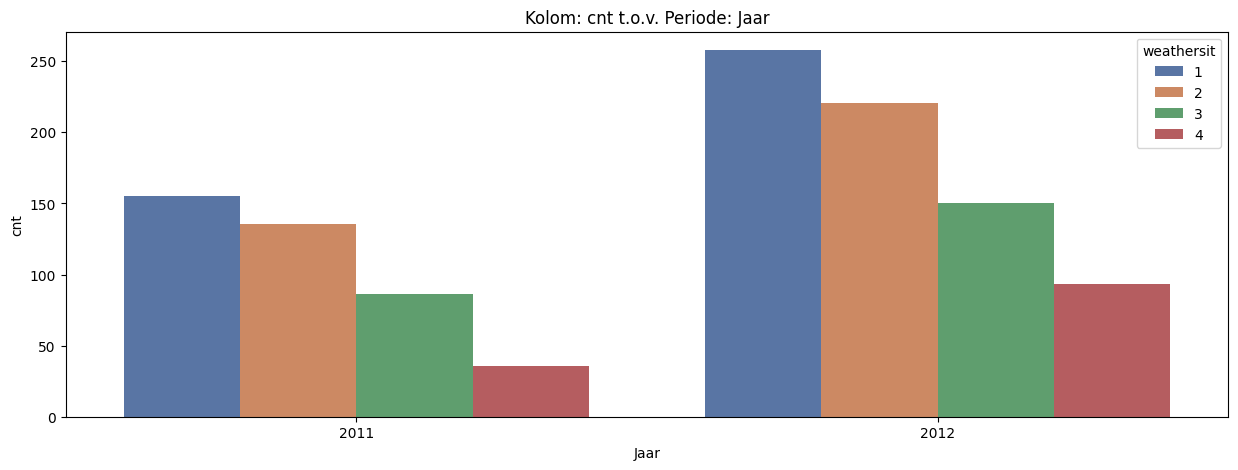

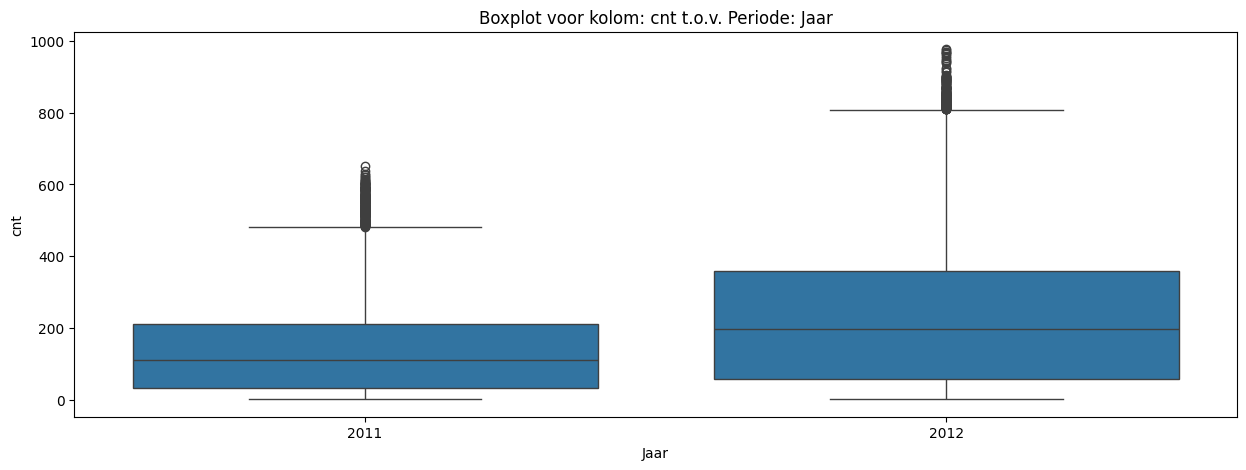

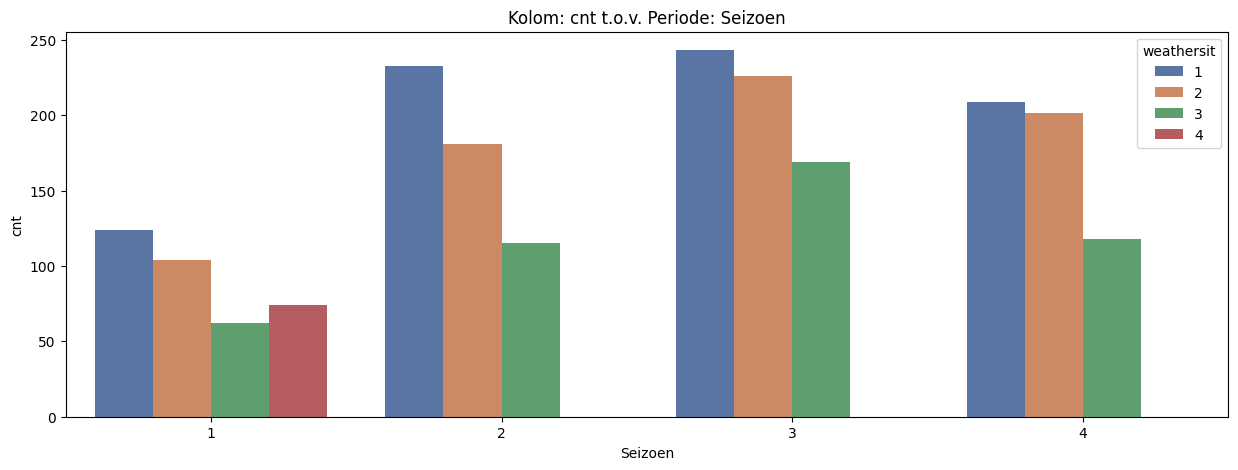

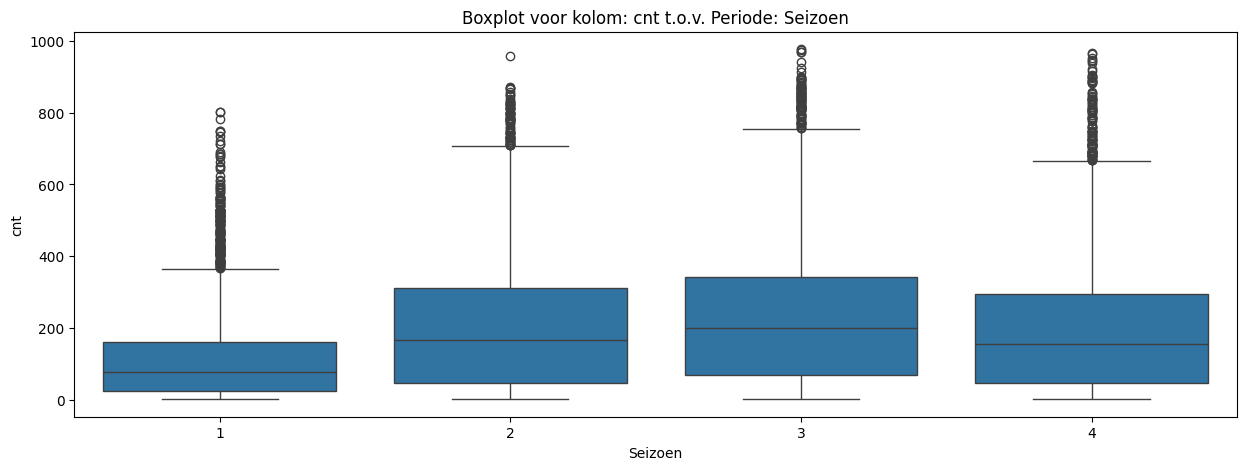

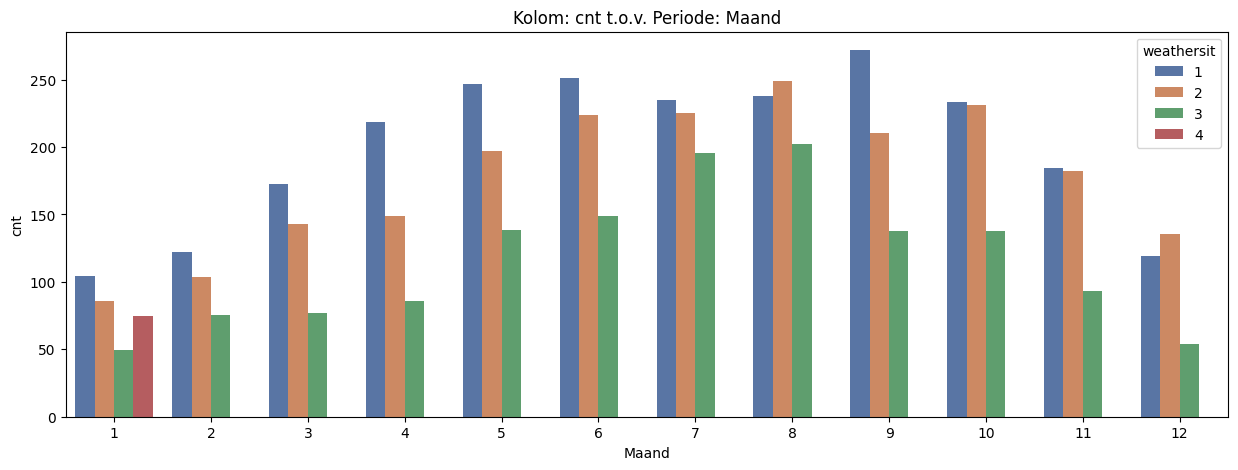

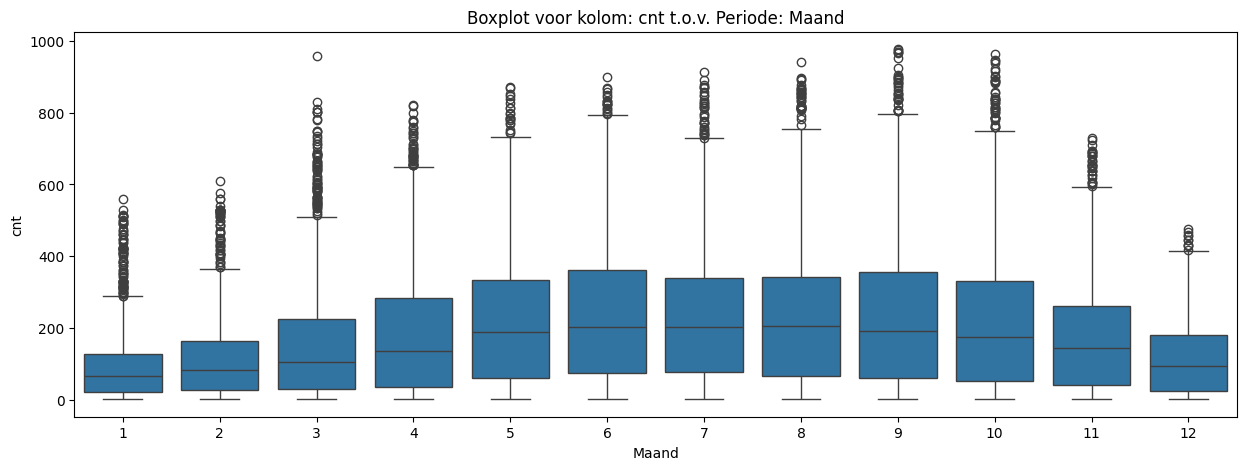

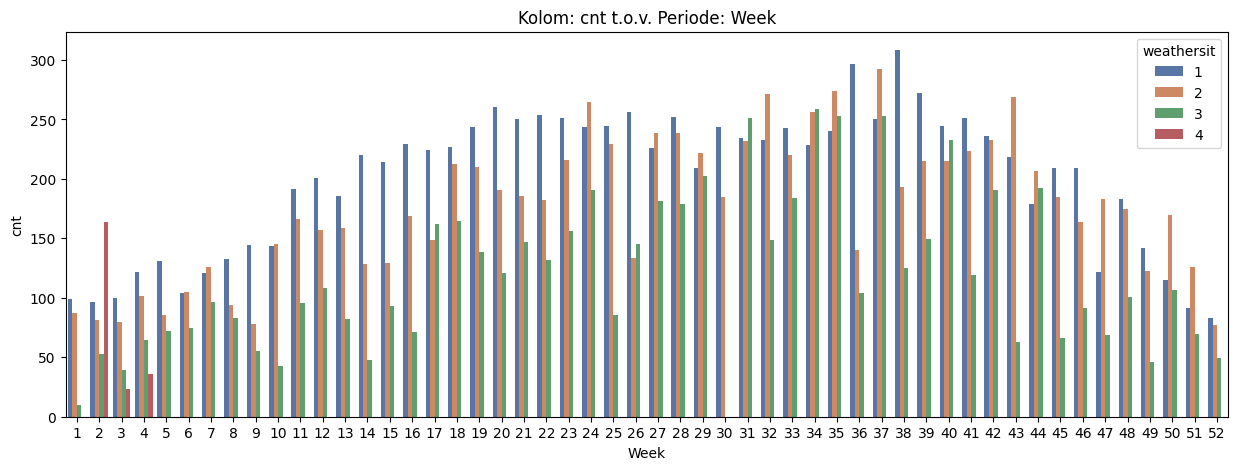

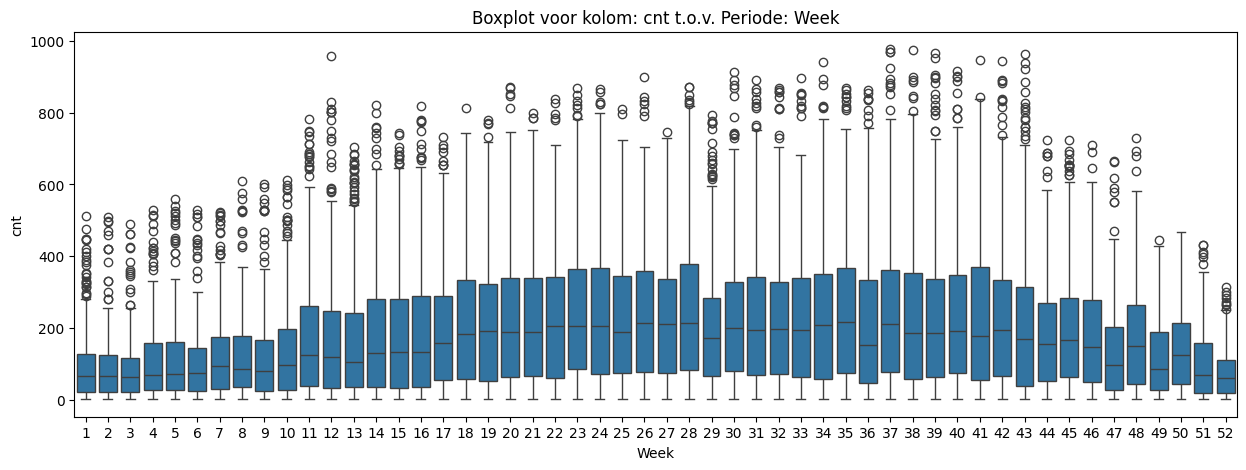

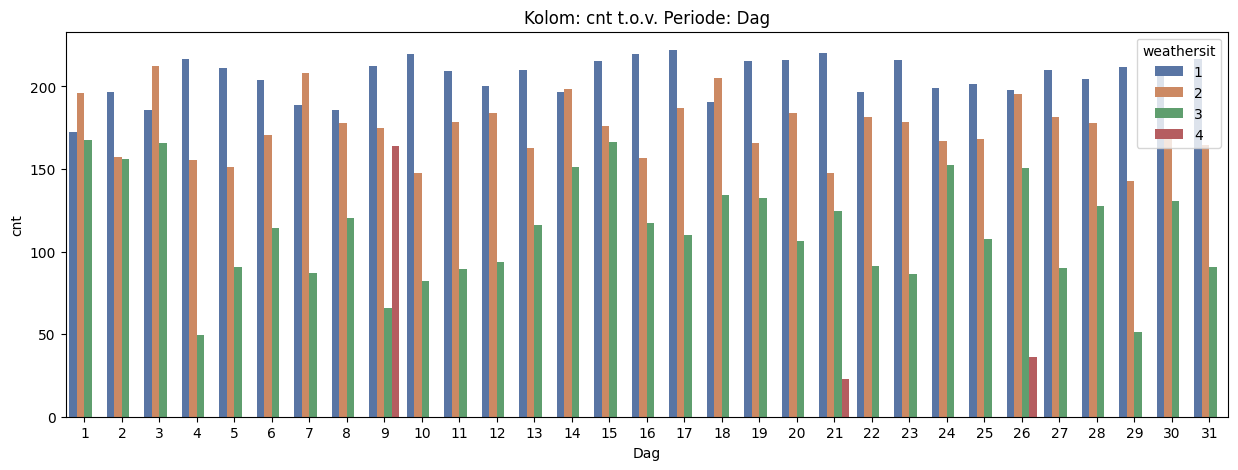

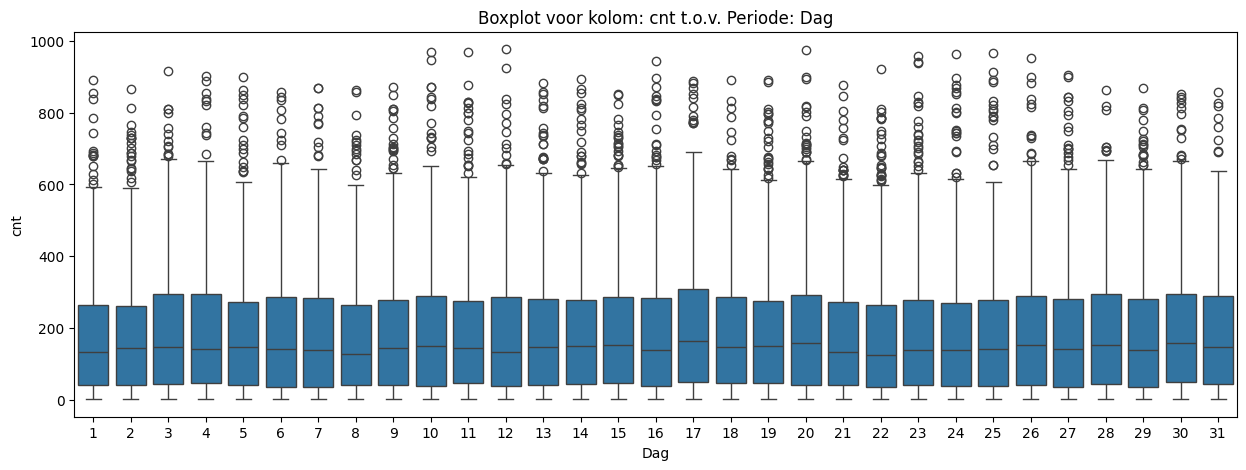

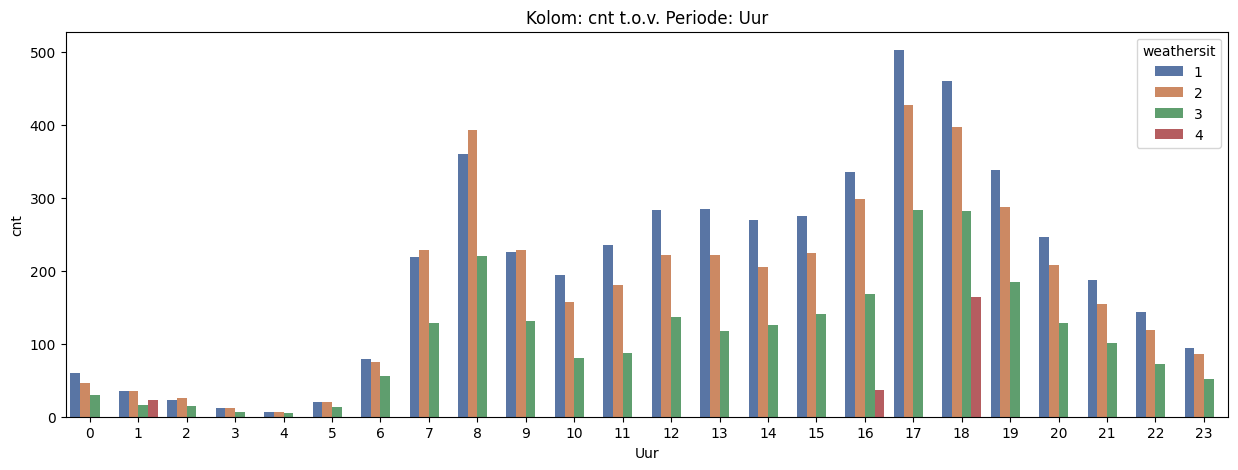

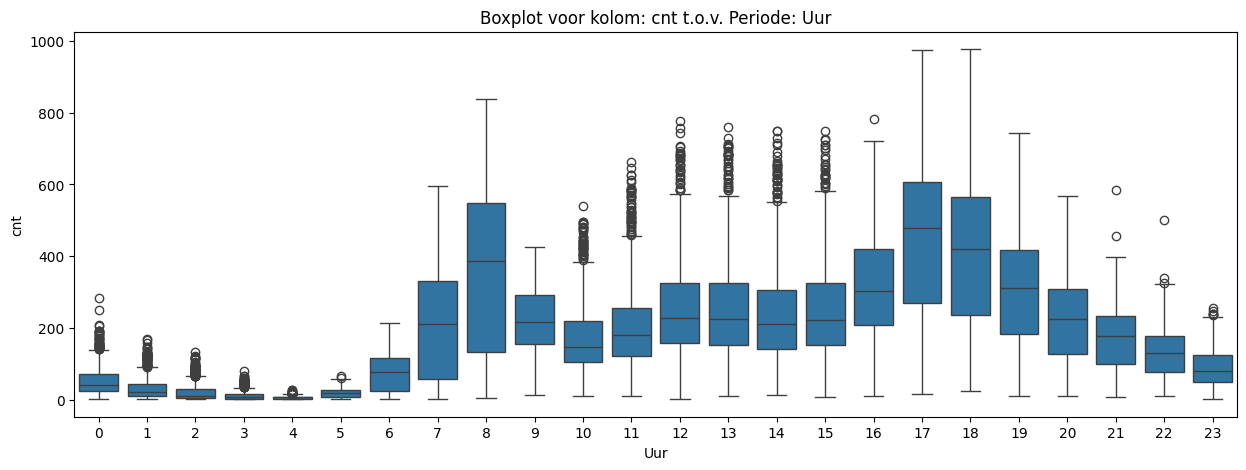

In [9]:
# Plotten voor tijdperioden
for tijd in tijden:
    visulisaties.plot_bar(x=tijd, y='cnt', hue='weathersit')
    visulisaties.plot_box(x=tijd, y='cnt')

Zoals hierboven te zien is, zijn er in 2012 en in de lente/zomer maanden meer verhuursaantallen. Dit is nog meer benadrukt door de hue instelling van de grafiek, waarbij de data ook is gesplitst op basis van weersituatie. Bij een klasse van 1 is er een algemeen hoger verhuur, dit neemt af narmate je omhoog gaat op de schaal. Hieronder is verduidelijking over de schaal van deze kolom:

**weathersit**:
1. Helder, licht bewolkt, deels bewolkt
2. Mistig , mistig en licht bewolkt
3. Lichte sneeuw, lichte regen, lichte regen en onweer, zwaar bewolkt, lichte
regen en zwaar bewolkt
4. Zware regen, hagel, zware mist, sneeuw.

Bij de boxplots is duidelijk te zien dat de mediaan in het midden van het jaar hoger ligt dan in het begin en einde van het jaar, wel zijn er elke keer veel uitschieters aan de bovenkant. Hieruit is op te maken dat er een algemene lagere verhuur kan worden verwacht met de plotselinge uitschieters elke week. Opvallend is ook dat er tijdens de uren 6 t/m 9 en 17 t/m 20 geen outliers te vinden zijn.

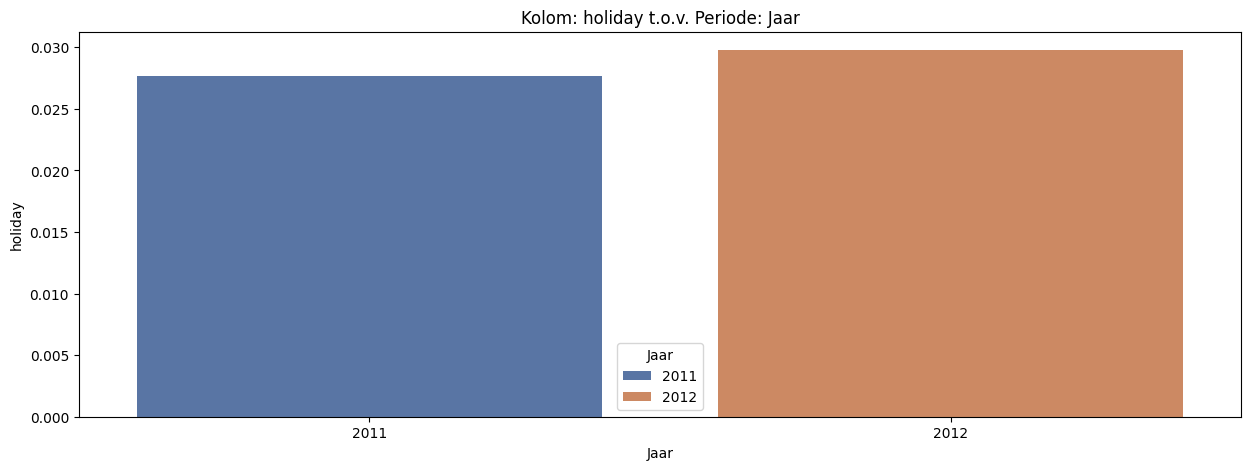

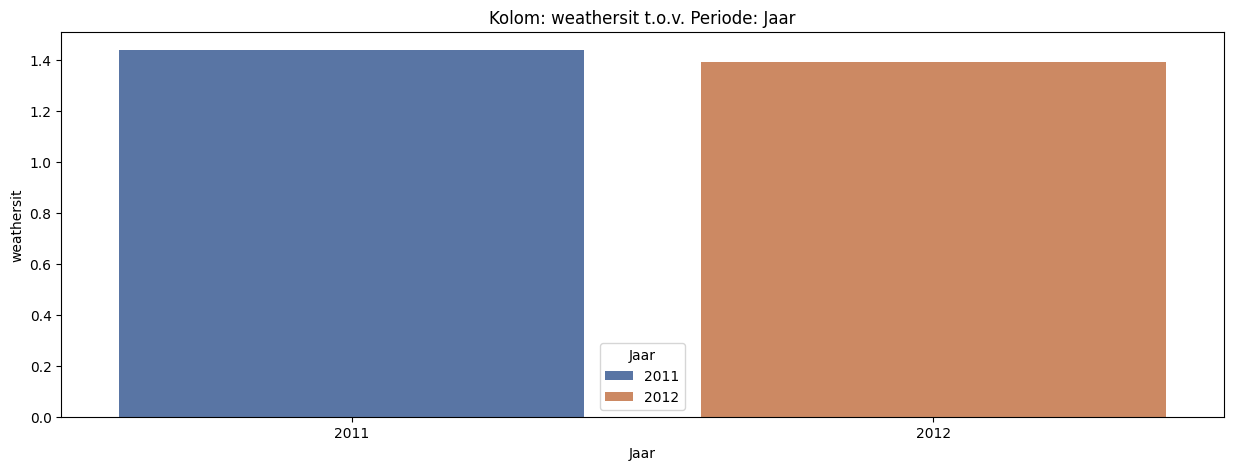

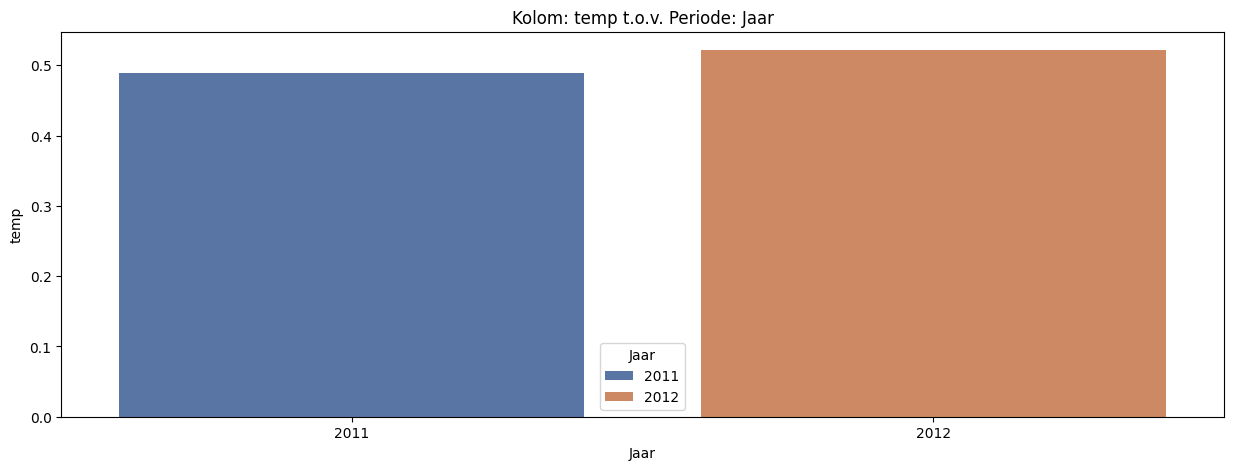

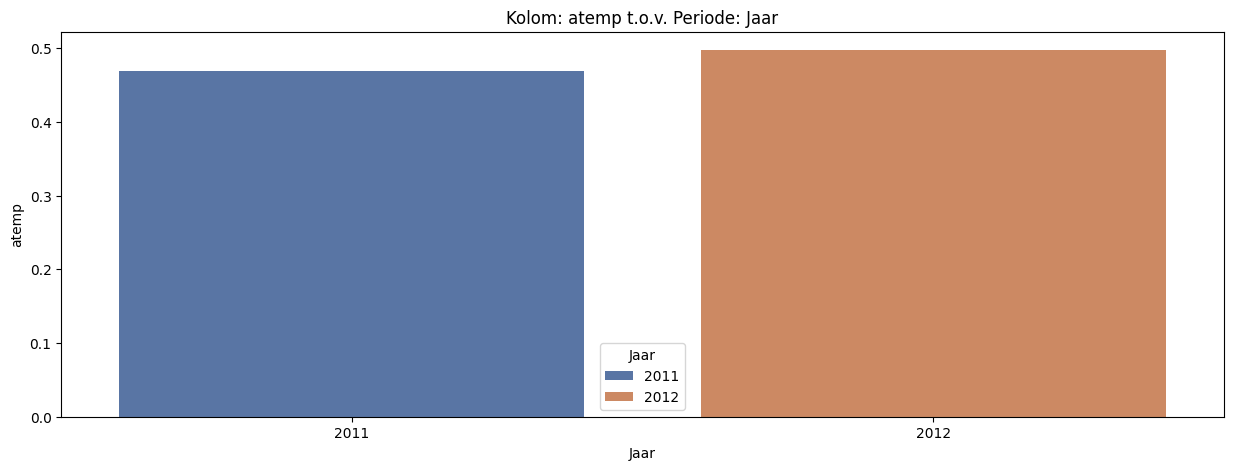

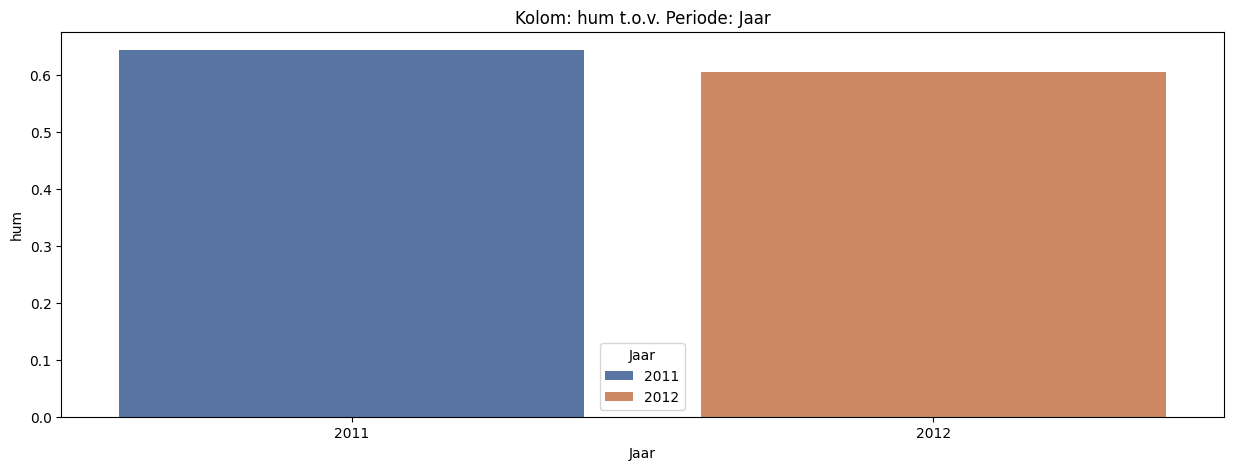

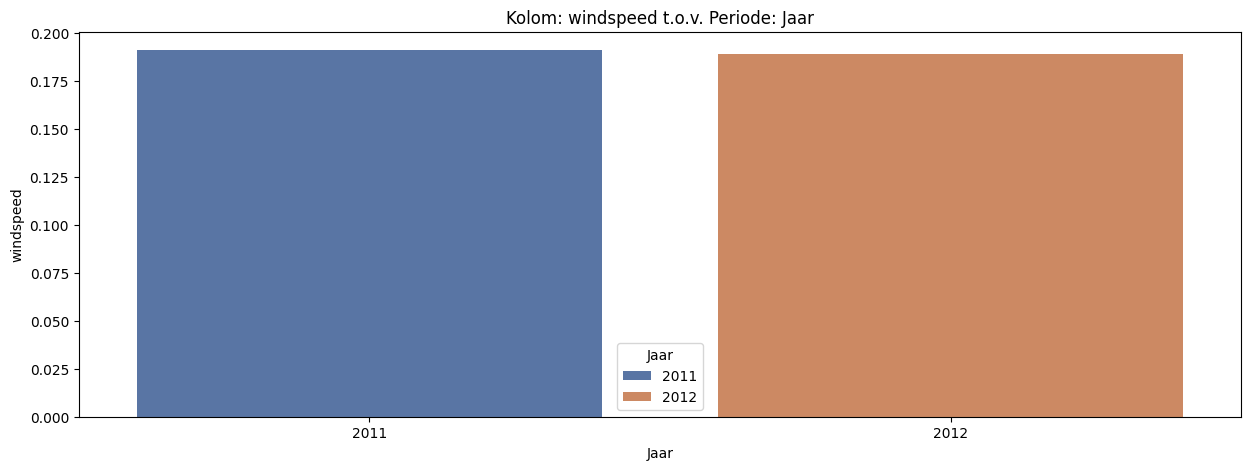

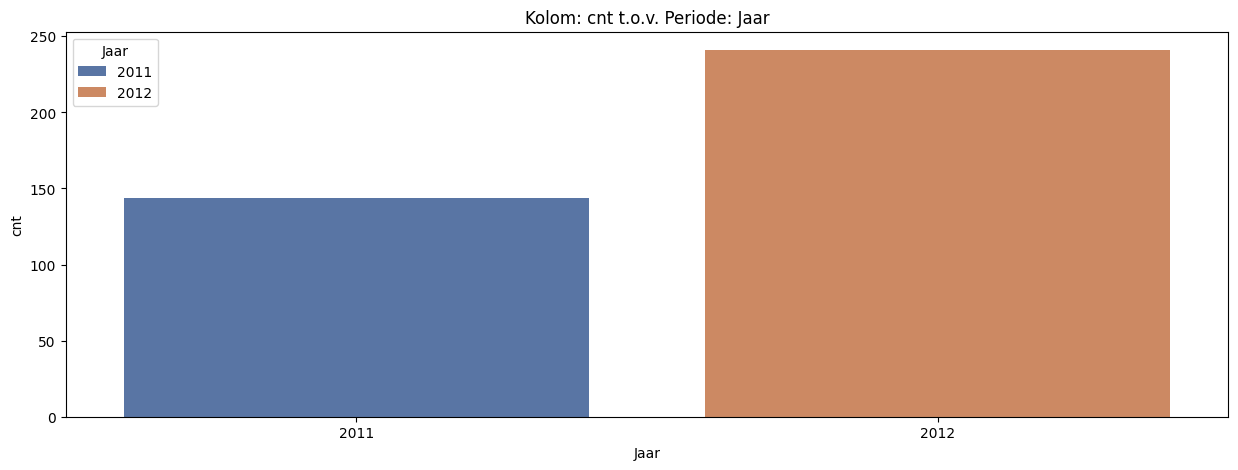

-------------------------------------------------------------------------------------------------------------------------------------------------


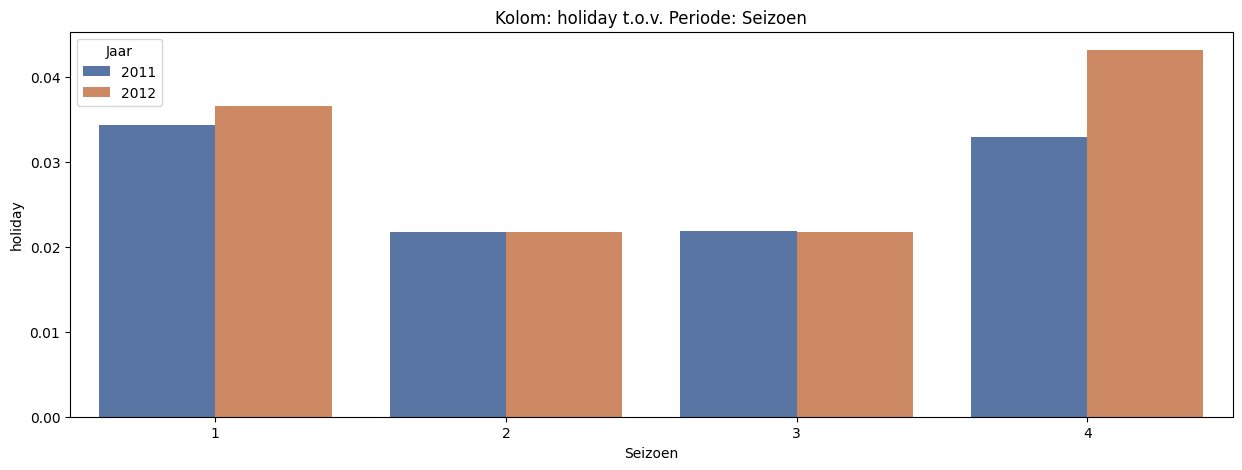

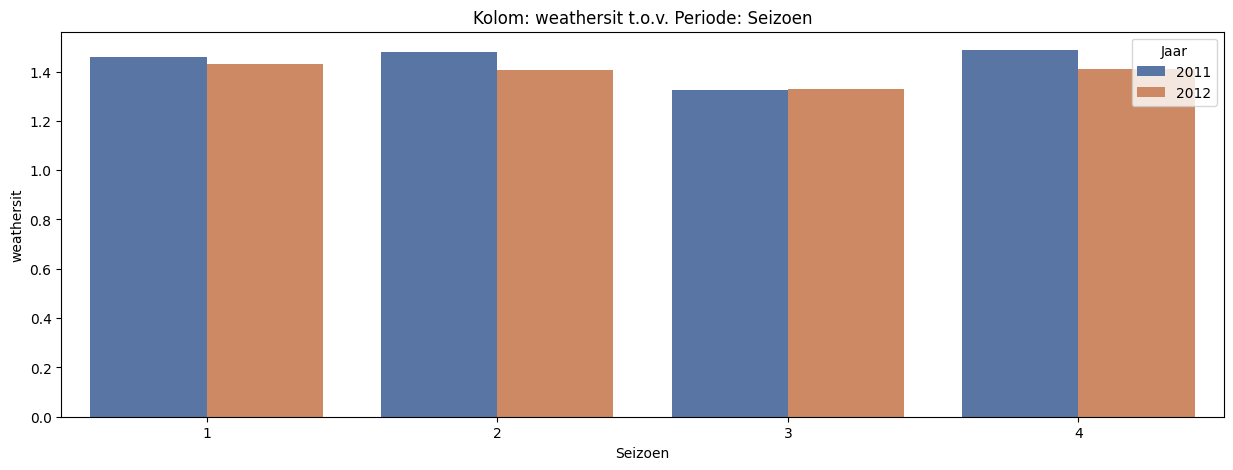

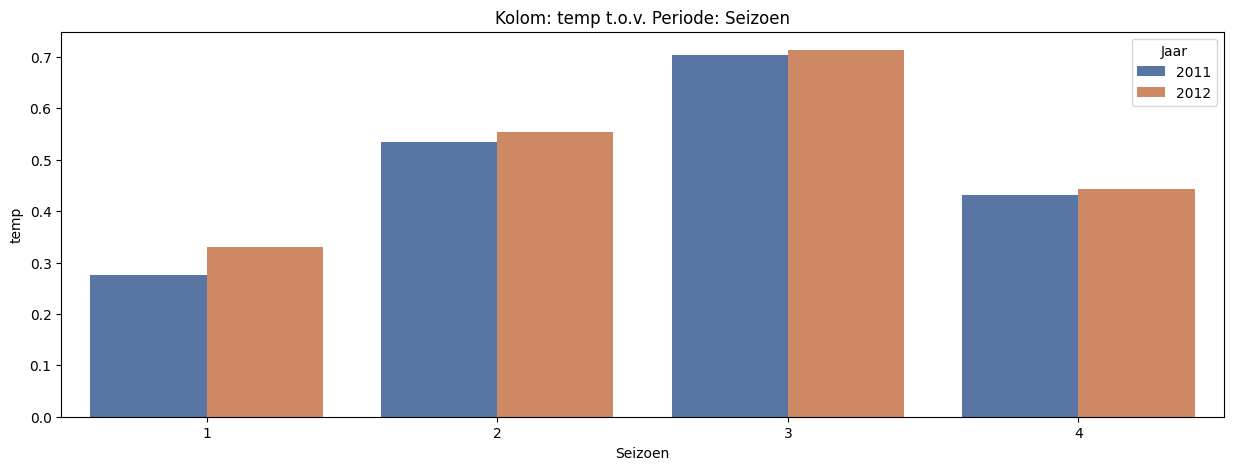

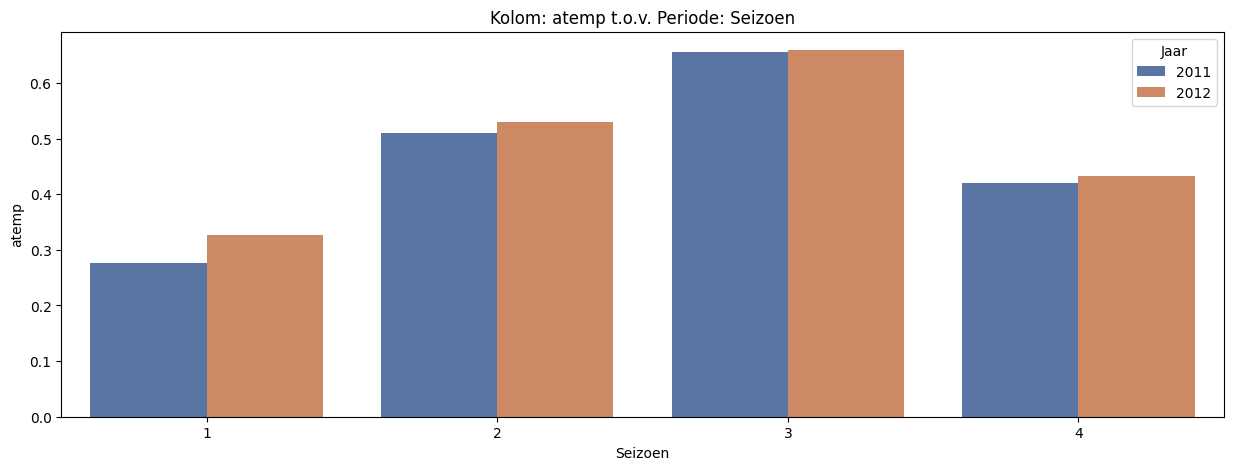

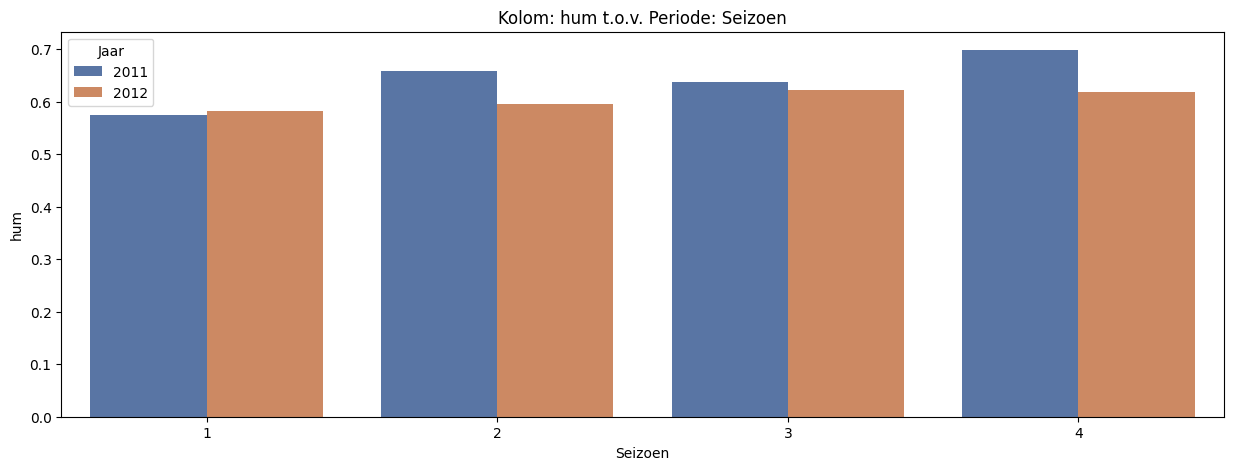

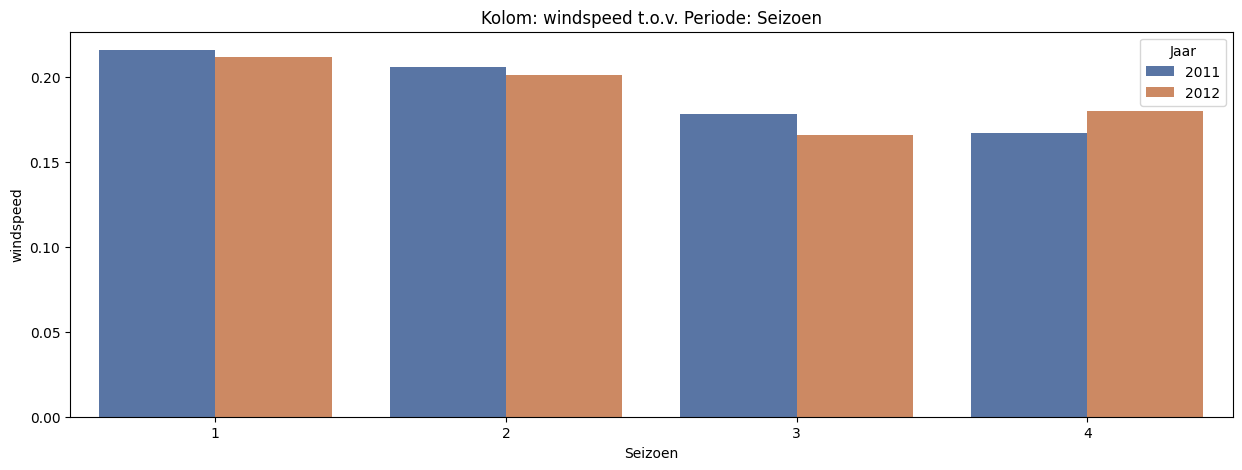

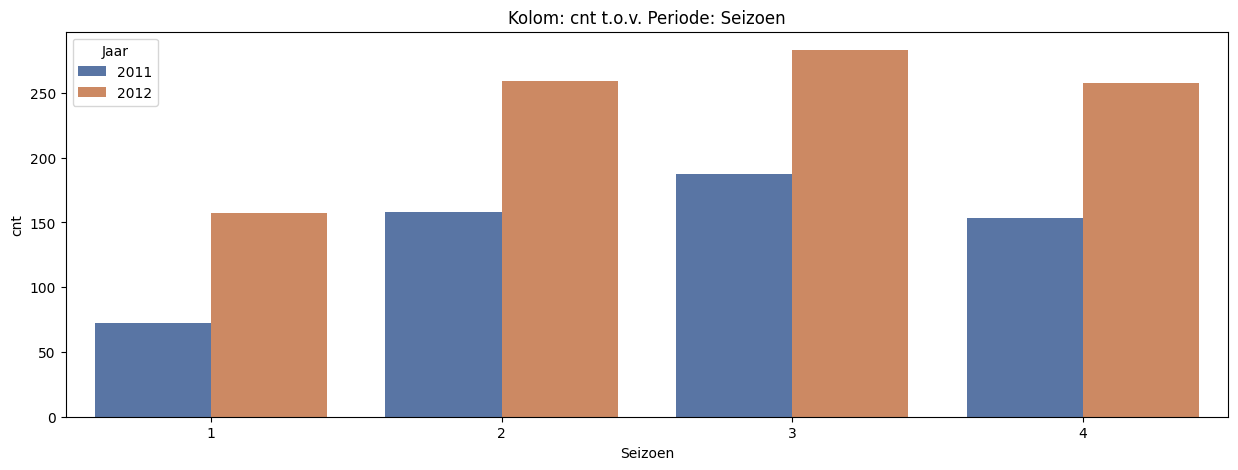

-------------------------------------------------------------------------------------------------------------------------------------------------


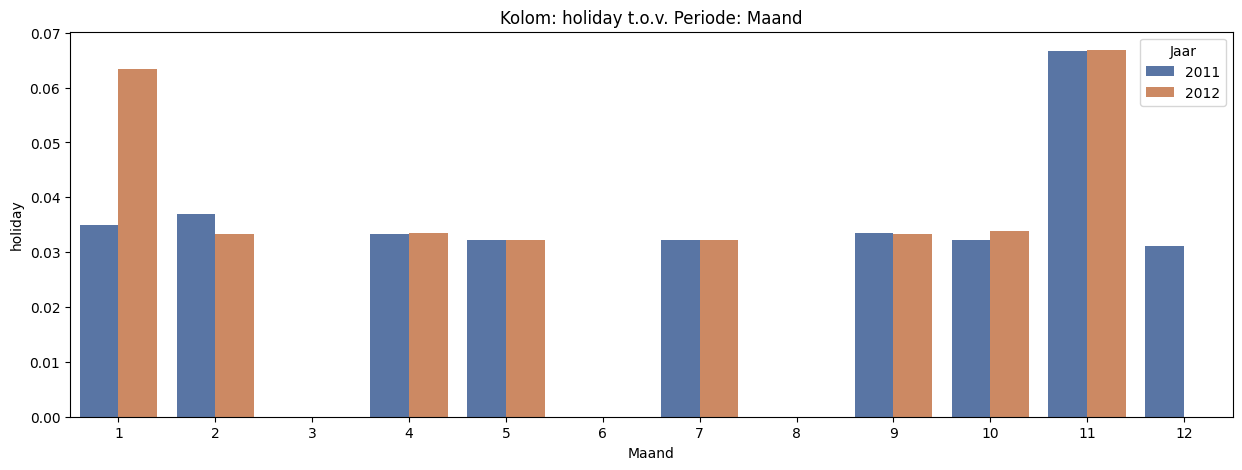

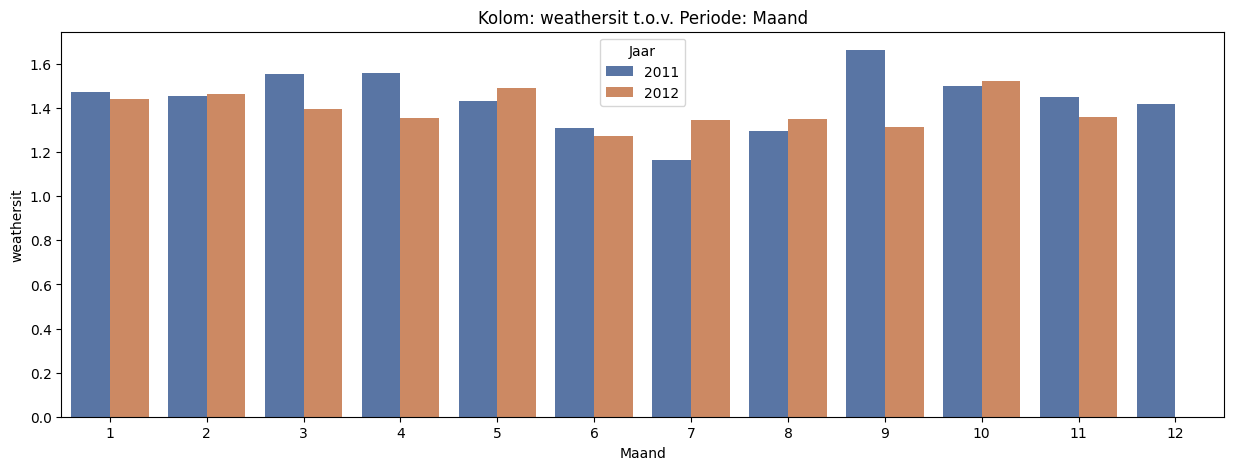

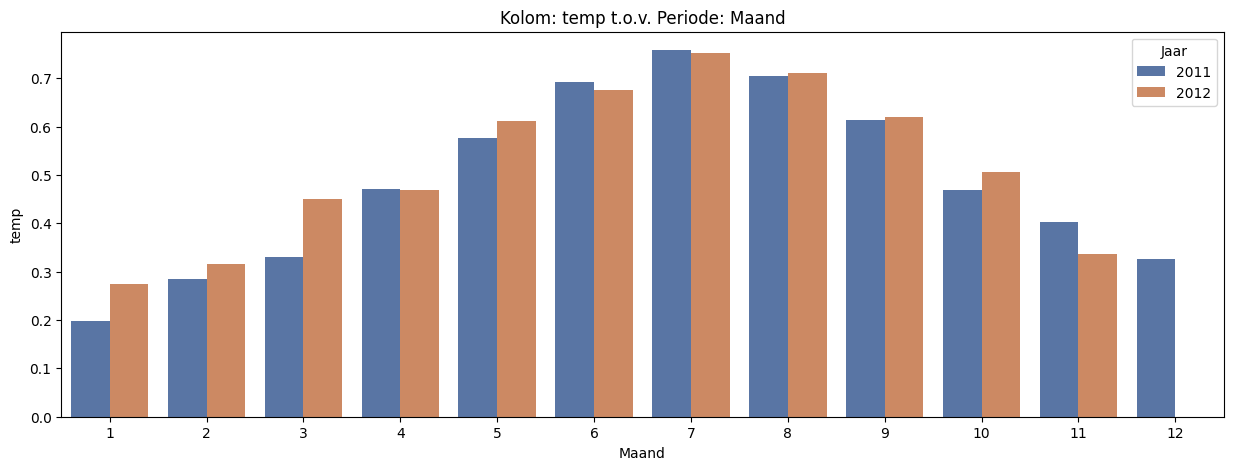

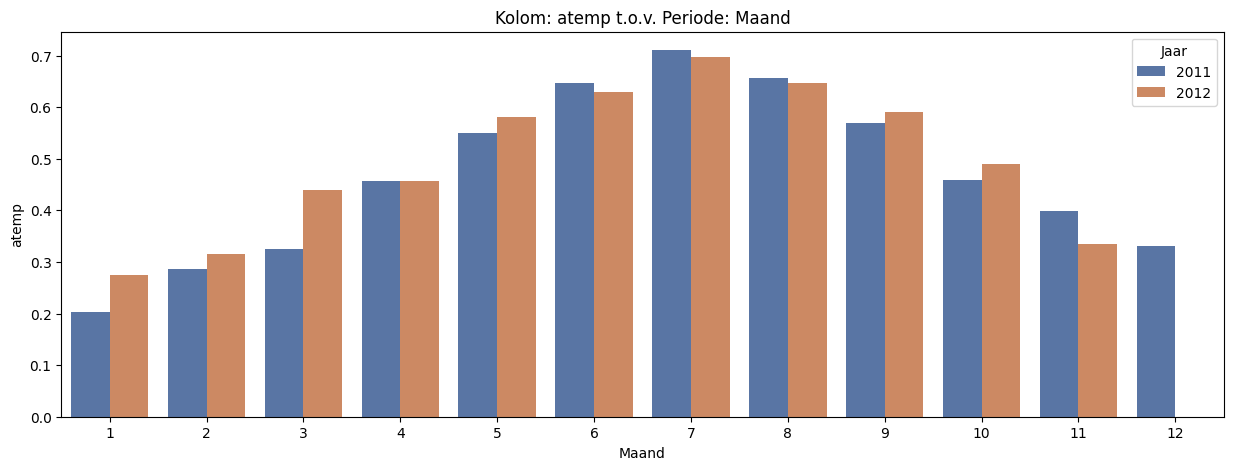

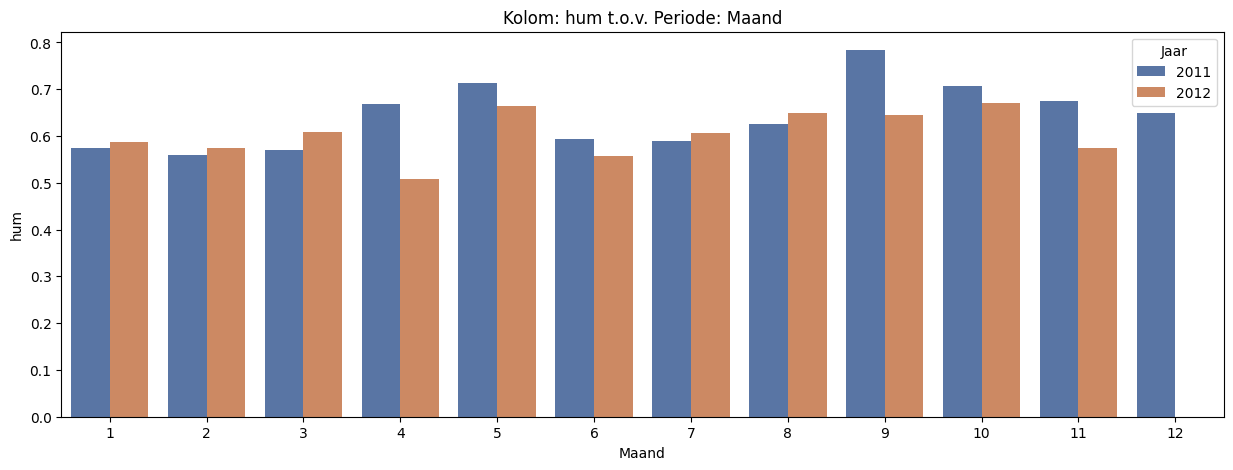

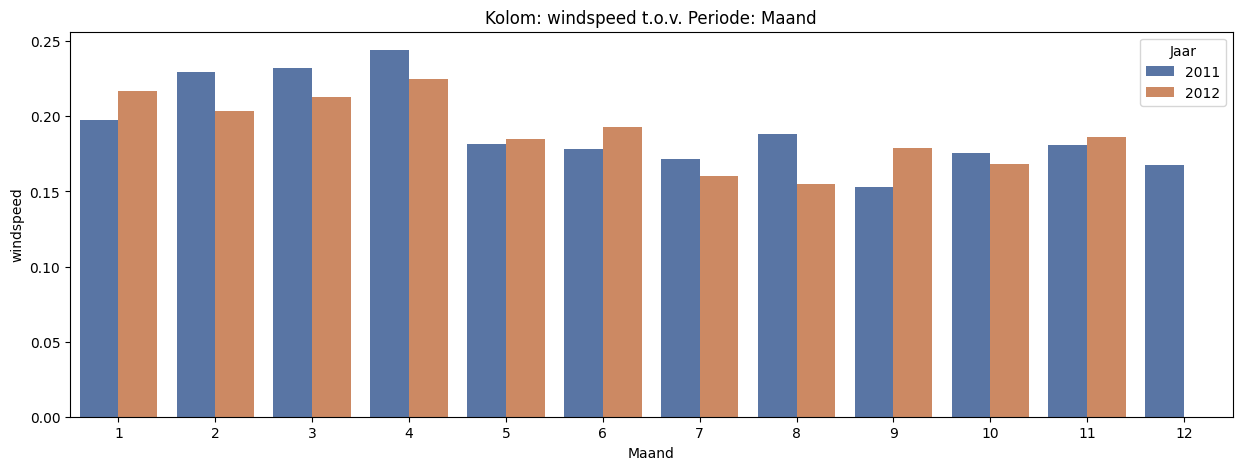

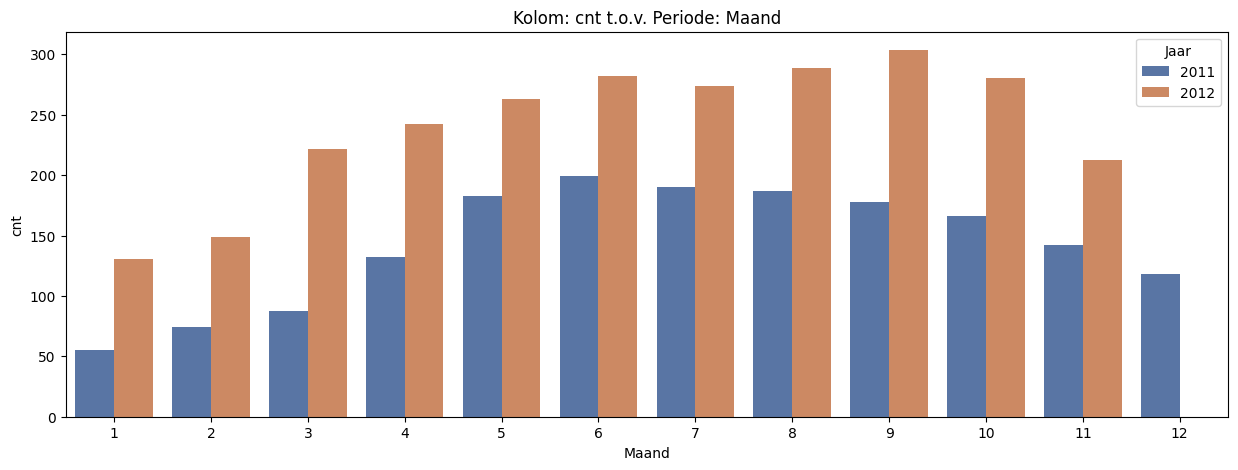

-------------------------------------------------------------------------------------------------------------------------------------------------


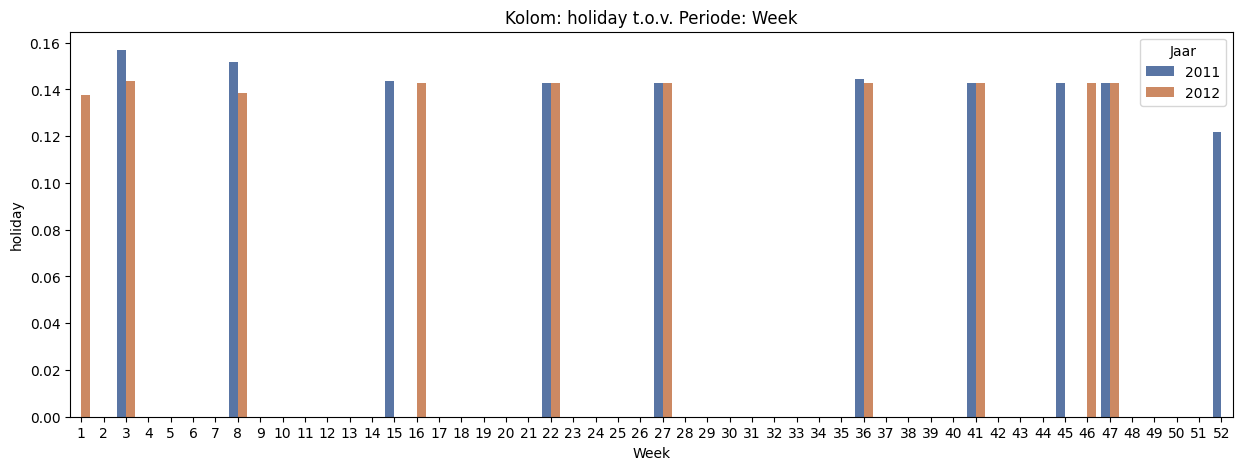

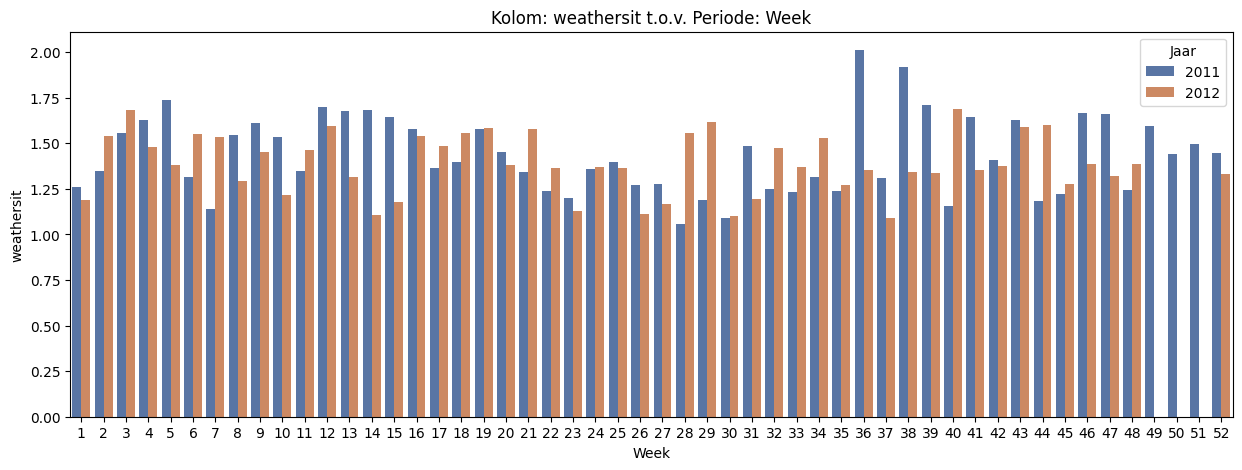

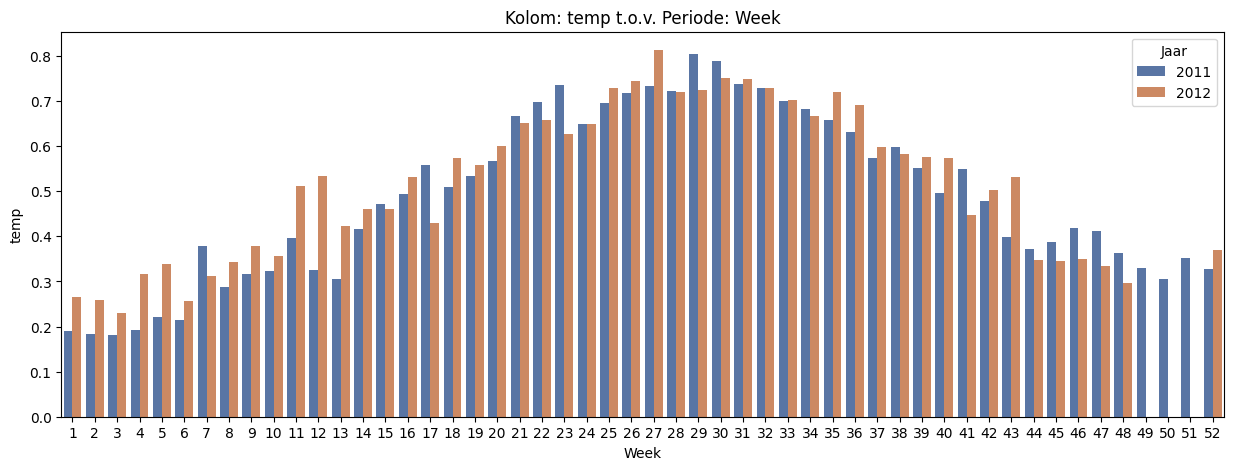

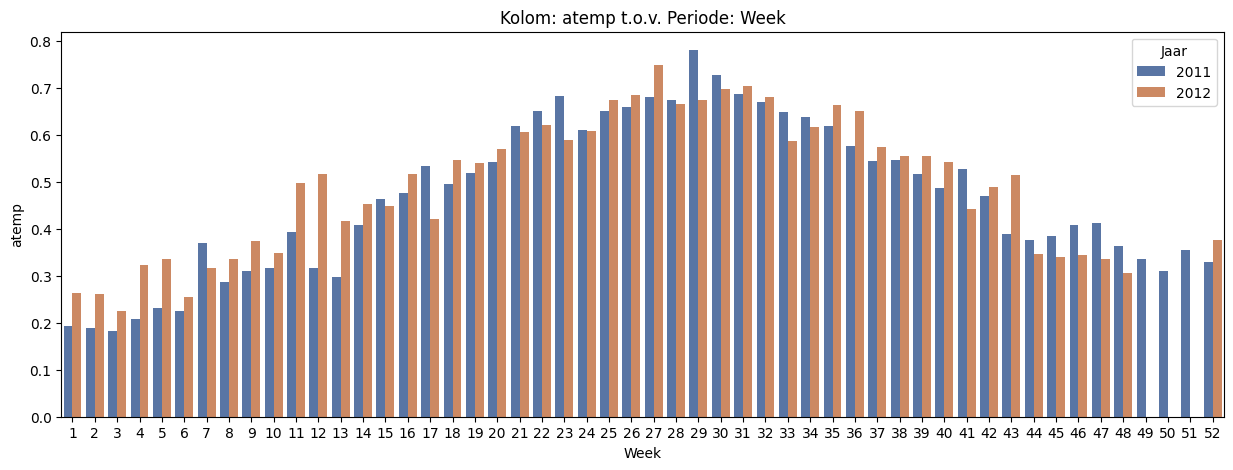

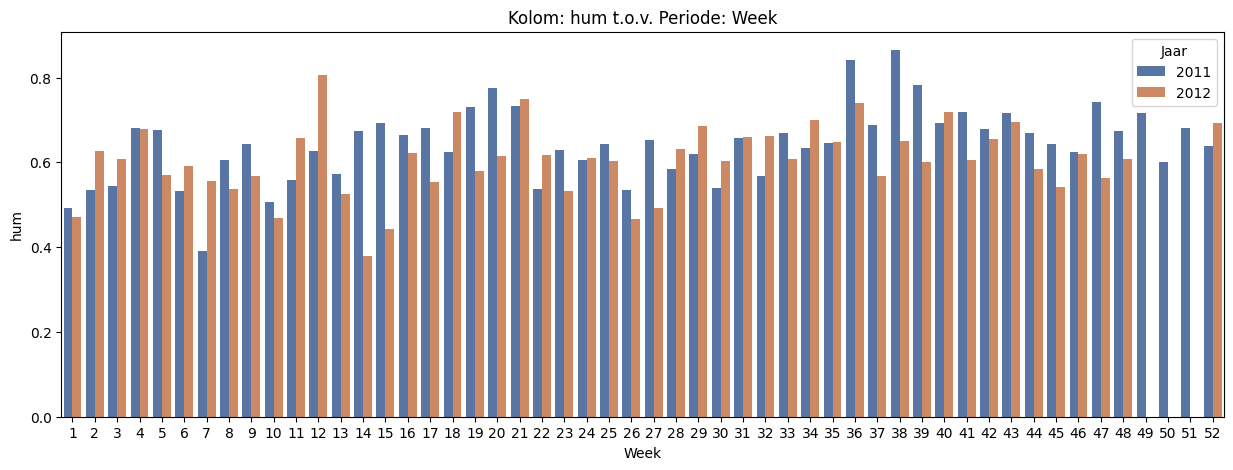

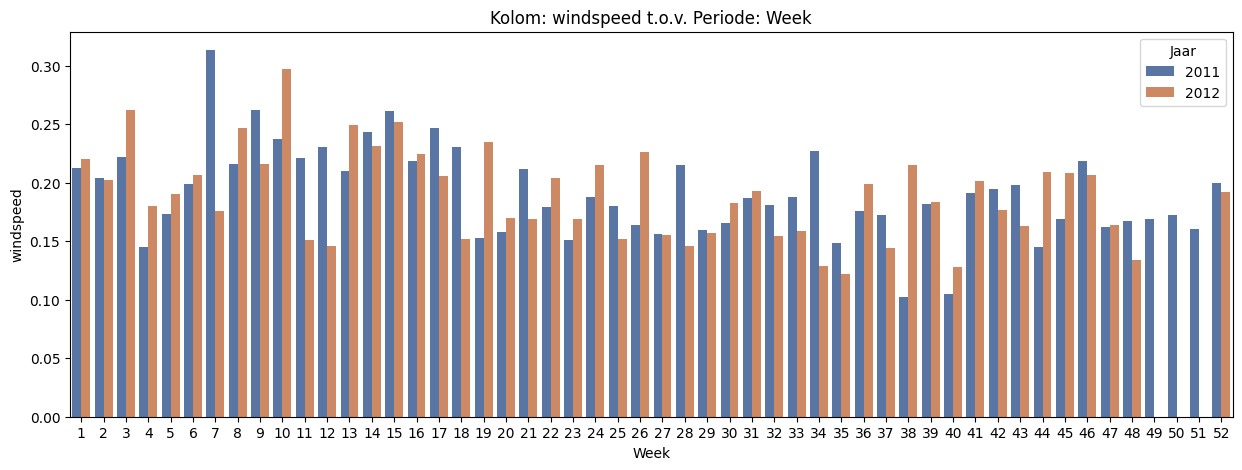

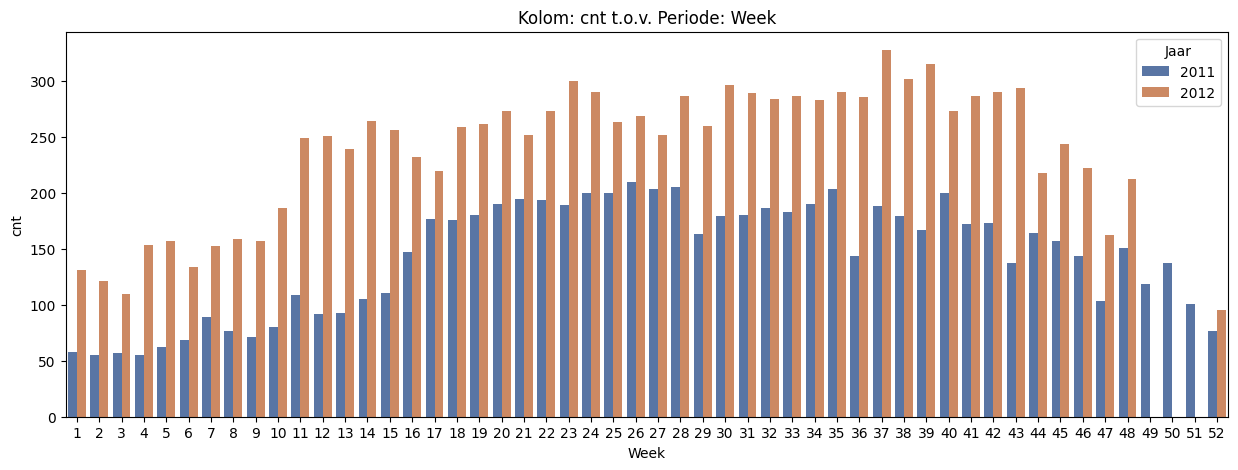

-------------------------------------------------------------------------------------------------------------------------------------------------


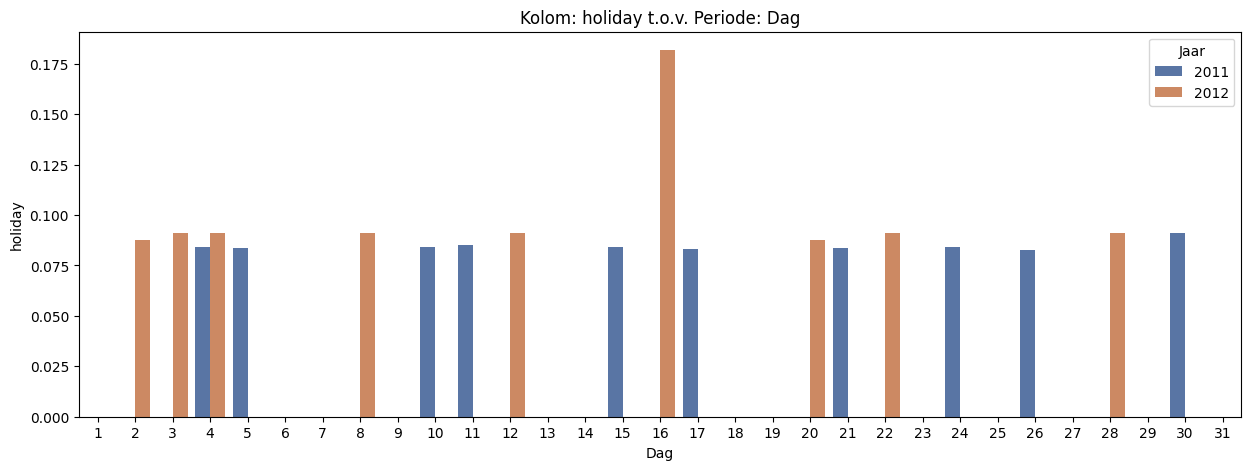

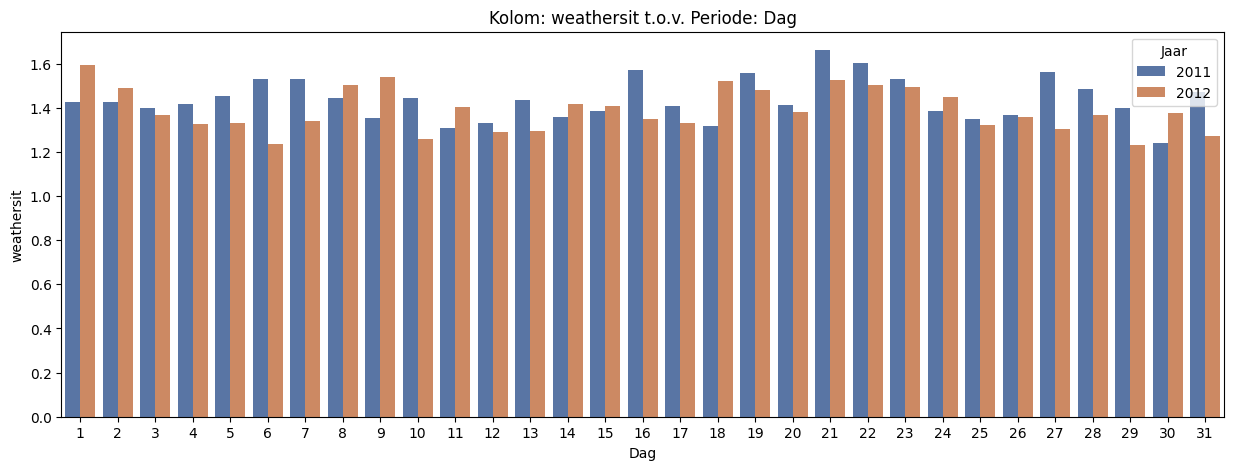

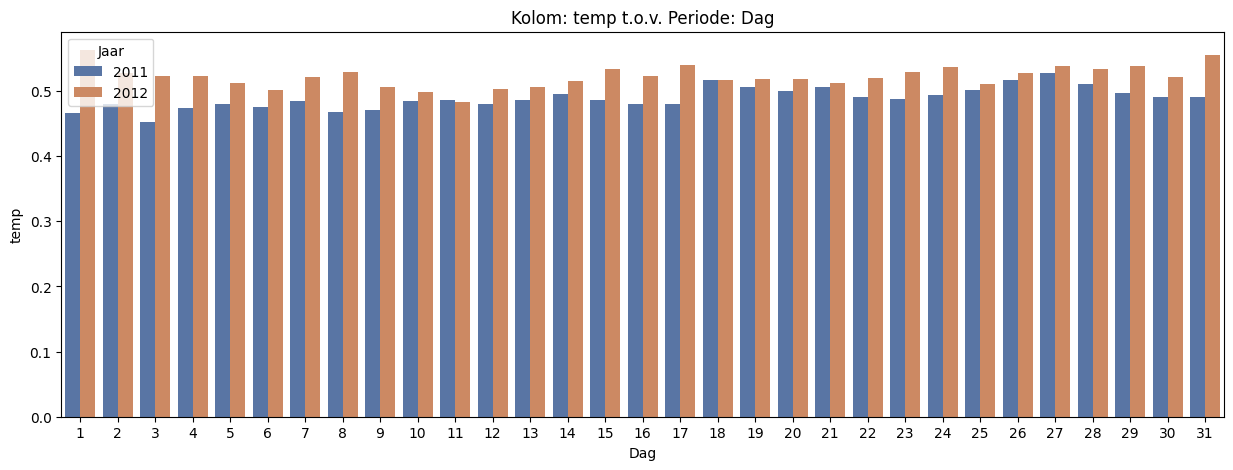

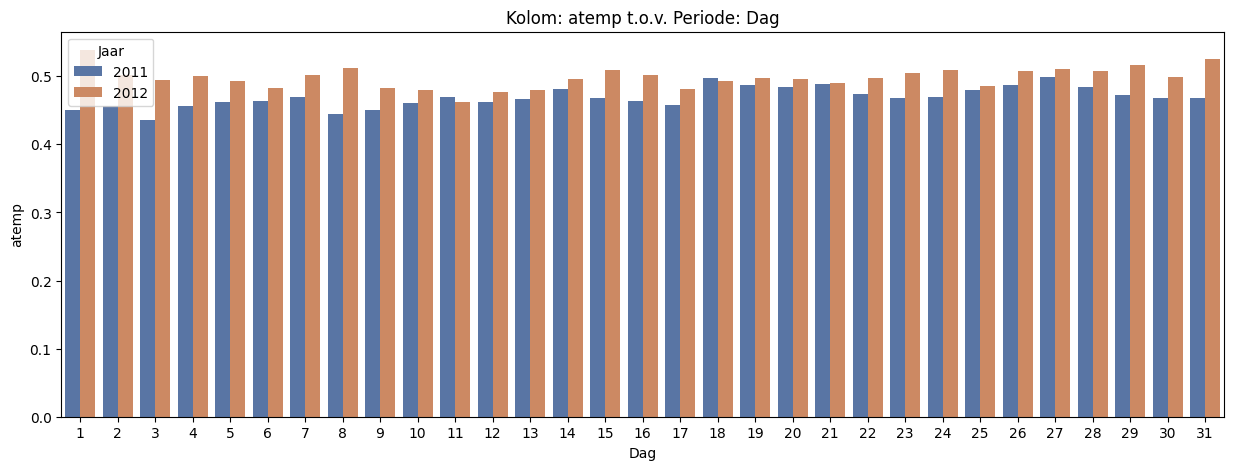

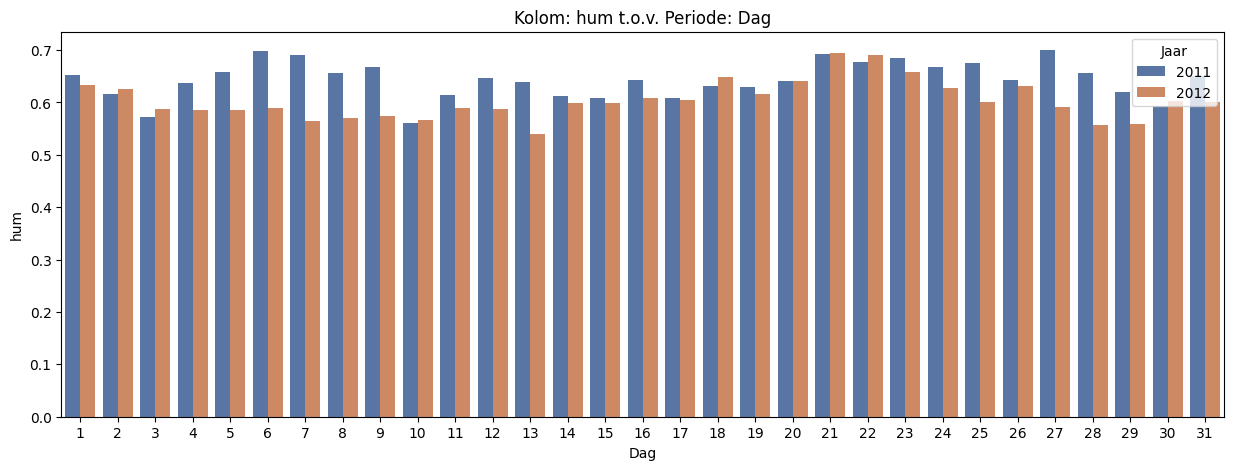

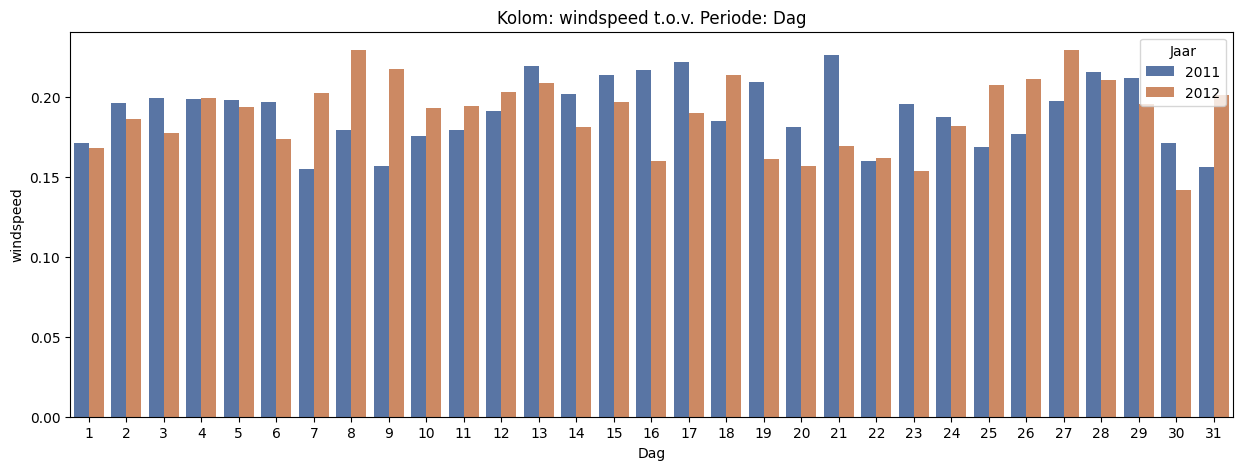

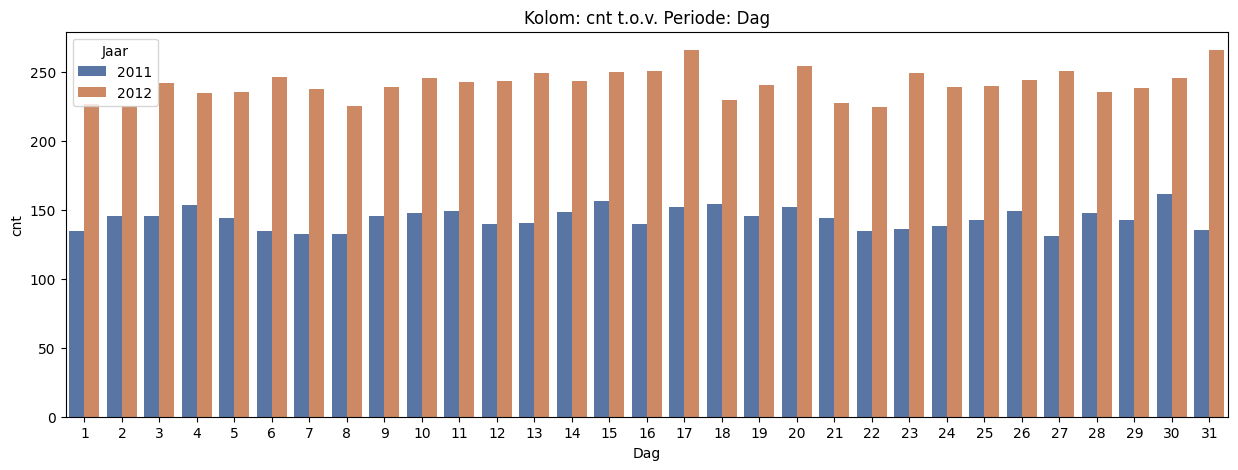

-------------------------------------------------------------------------------------------------------------------------------------------------


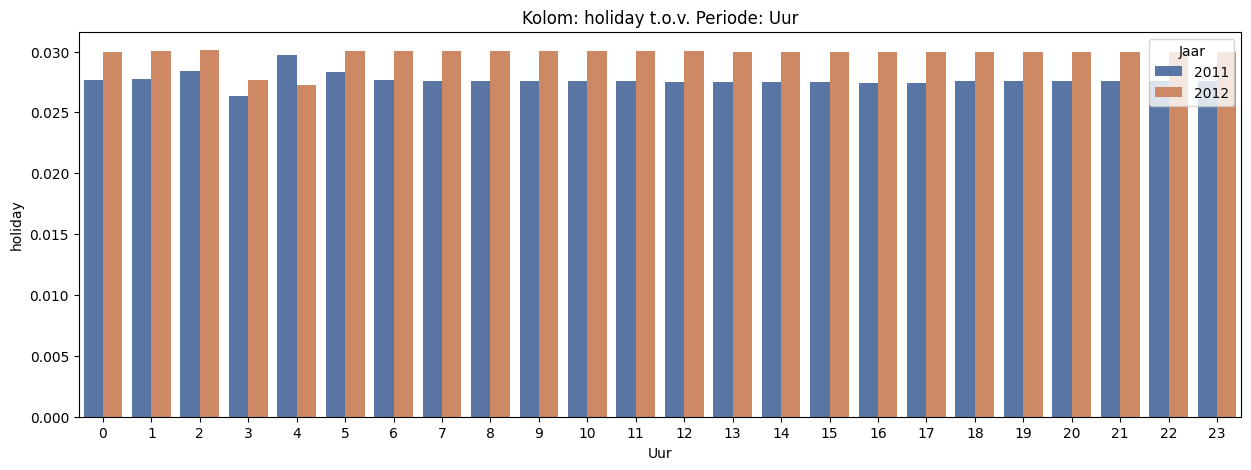

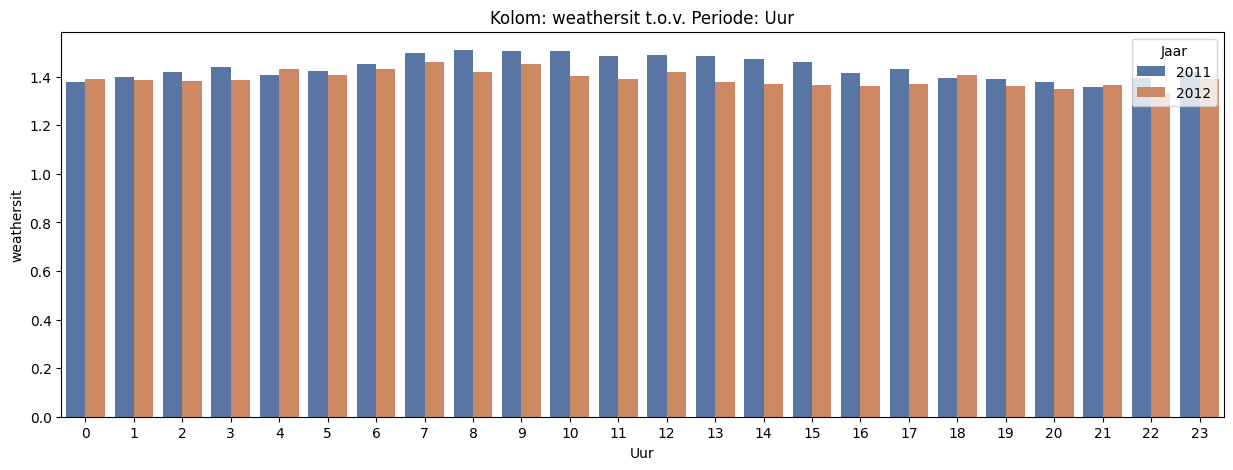

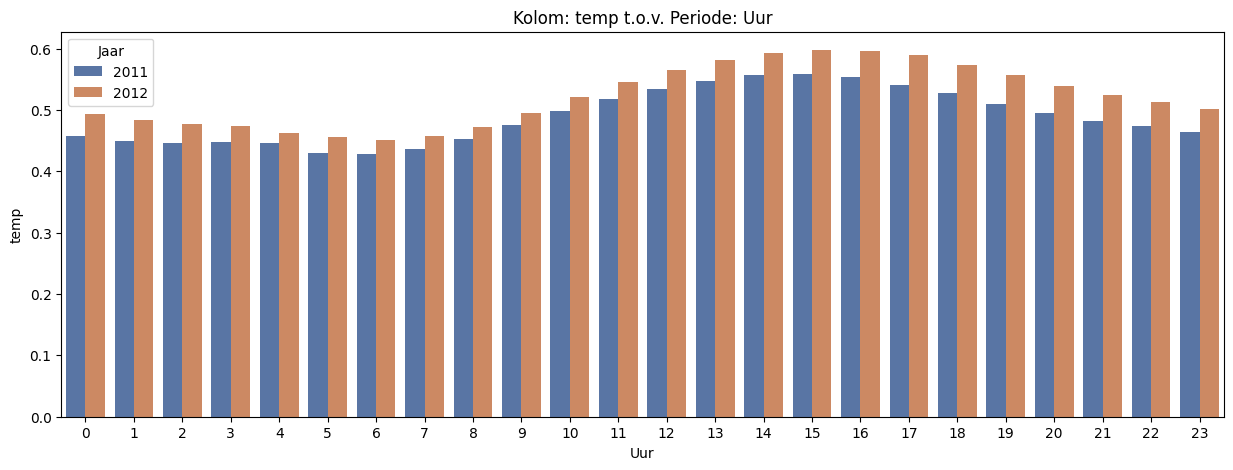

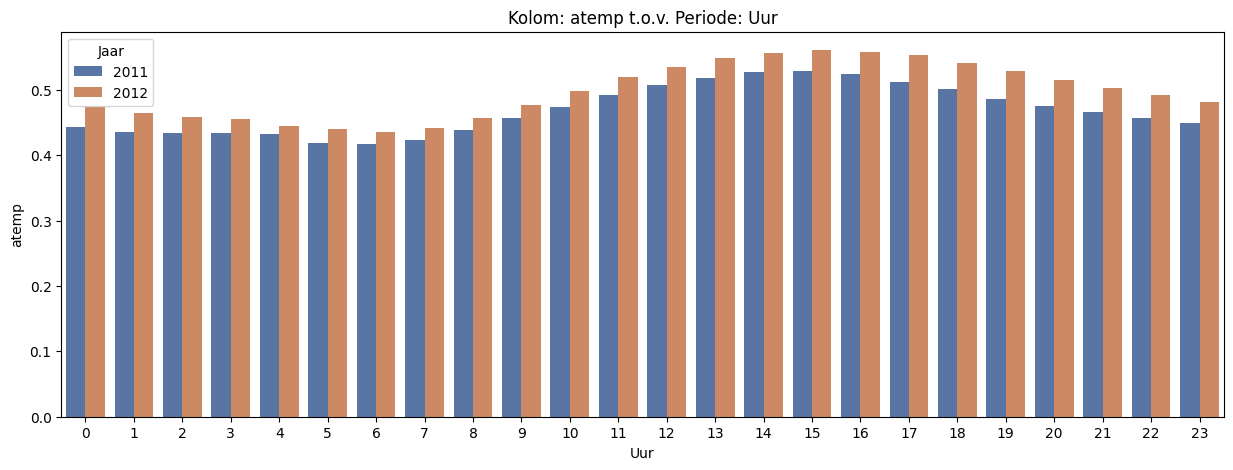

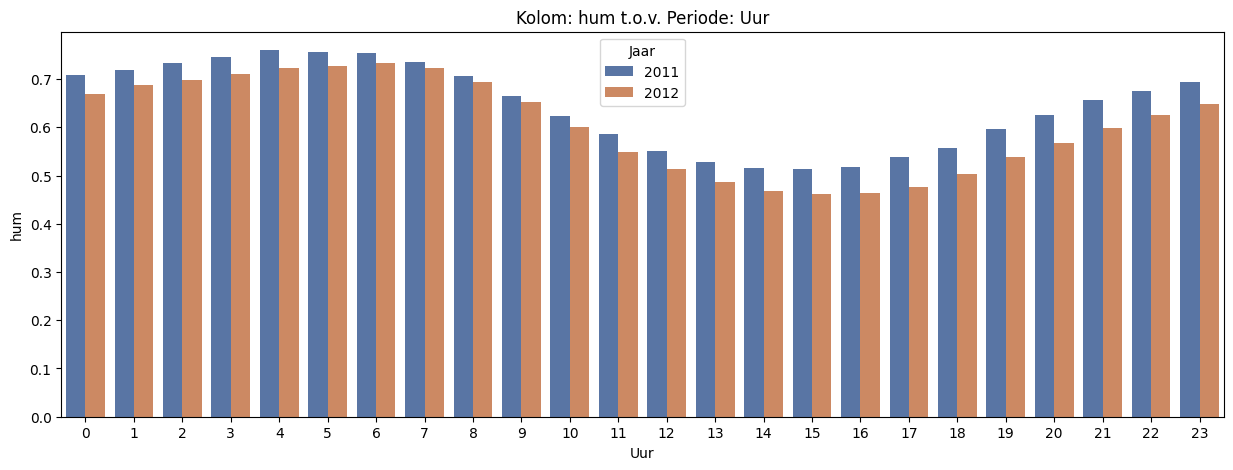

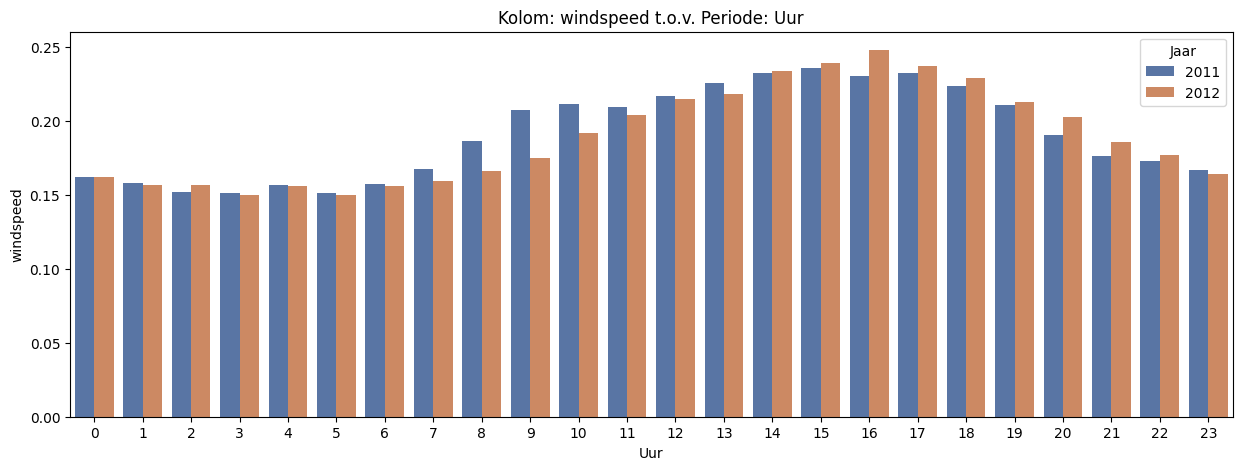

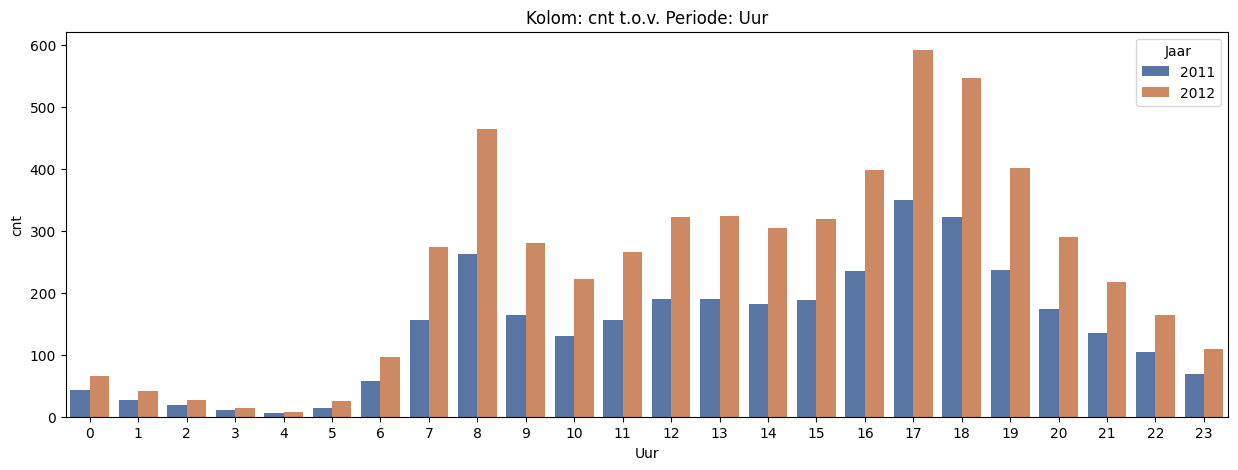

-------------------------------------------------------------------------------------------------------------------------------------------------


In [10]:
# Plotten voor kolommen t.o.v. verschillende perioden
for tijd in tijden:
    for col in kolommen:
        visulisaties.plot_bar(x=tijd, y=col, hue='Jaar')
    print('-----' * 29)

Bij de grafieken per jaar is er geen duidelijk verschil op te merken, behalve bij het verhuursaantal. Bij deze variabele is het verschil duidelijk, in het voordeel van het bedrijf. Ook valt te zien dat de waarden voor temperatuur hoger zijn in het jaar 2012. 

Wat erg opvalt bij de seizoensverdeling is dat de seizoenen 2 en 3 (lente en zomer) het beste presteren in temperatuur en verhuuraantallen. Wat daarbij ook opvalt is dat in deze perioden de holiday parameter het laagste is. Dit geeft extra benadrukking op de voorgaande ondervindingen over de temperatuur en het weer.

Bij de maandelijkse grafieken is te zien dat de temperatuursverschillen afhangen van de maand. Hoewel het in sommige maanden beter weer was dan het voorgaande jaar (bijvoorbeeld maart), was het in andere maanden net slechter (bijvoorbeeld juli). Ook valt het op dat er in 2012 een tweede piek voor de verhuuraantallen ontstond in september, terwijl dit in 2011 bleef dalen na augustus. 

Deze trend is ook bij de weekaantallen te merken. De weken van september hebben beter weer, waardoor het aannemelijk is dat dit heeft meegespeeld met de tweede piek in verhuuraantallen. Ondanks dat de temperatuur lager is in sommige weken zijn de verhuuraantallen significant hoger per week. 

Zoals verwacht is de dagelijkse hoeveelheid (gebaseerd op dagnummer van de maand) nagenoeg gelijk aan elkaar. Dit is logisch gezien dat de meeste maanden elke dag bevatten, waardoor de data als gemiddelde is gestabiliseerd. 

Echter geven de uren iets meer inzicht dan verwacht. Rond de uren 8 en 17/18 zijn de verhuuraantallen behoorlijk hoger dan bij de rest. Wat opvalt aan deze tijden is dat de temperatuur over het algemeen begint met stijgen om 8 uur en begint met weer te dalen rond 16 uur. Rond deze tijden gebeurt hetzelfde met de windsnelheid, deze informatie was in vorige vormen van visualiseren niet te zien. Daarnaast daalt de luchtvochtigheid juist rond 8 uur en begint deze met stijgen rond 16 uur, dit is precies het tegenovergestelde van de temperatuur en windsnelheid.

Naast deze bevindingen is het ook duidelijk te zien dat de algemene temperatuur (en windsnelheid na 14) hoger is dan het voorgaande jaar, ook dit is omgekeerd bij de luchtvochtigheid.

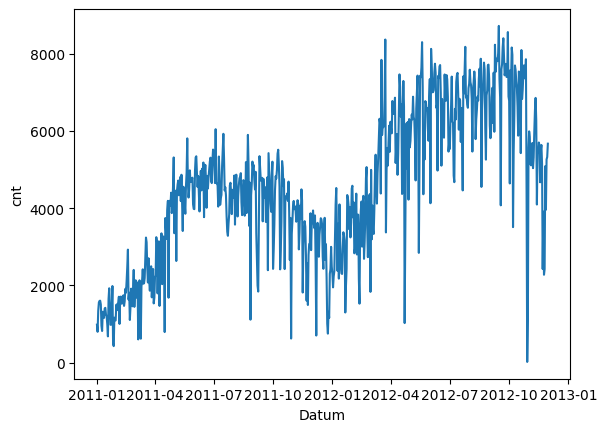

In [11]:
df_day = df.groupby(['Datum'])['cnt'].sum().reset_index()

# Tijdsverloop t.o.v. verhuur
sns.lineplot(data=df_day,
             x='Datum',
             y='cnt')
plt.show()

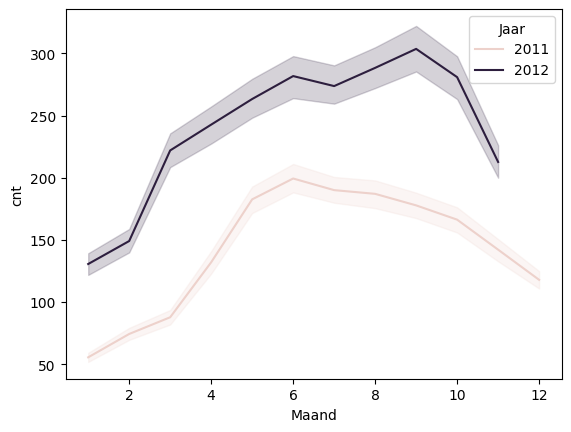

In [12]:
# Tijdsverloop t.o.v. verhuur
sns.lineplot(data=df,
             x='Maand',
             y='cnt',
             hue='Jaar')
plt.show()

Wat opvalt aan de grafieken is dat het twee bogen zijn, die stijgen aan het begin van het jaar en dalen richting het einde. Hoewel ze dalen, blijven ze wel hoger dan de start van het jaar.

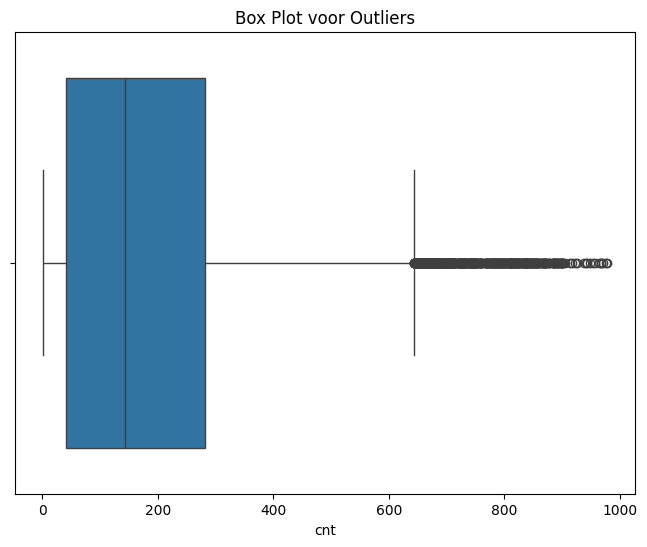

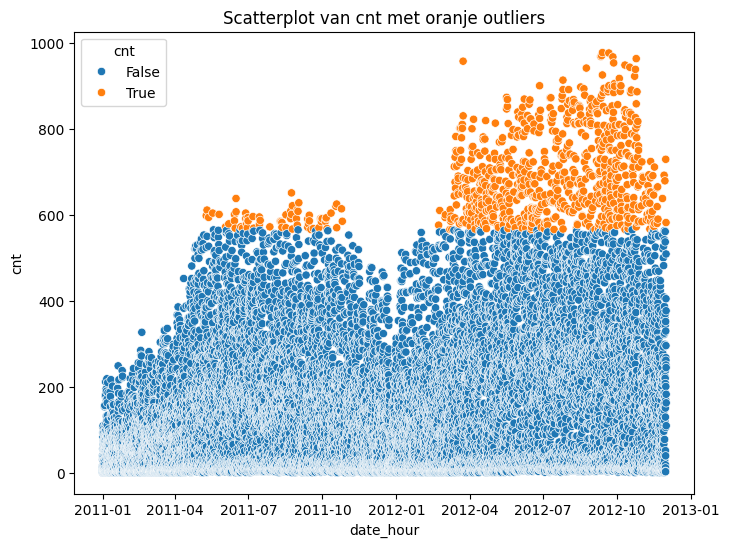

In [13]:
# Makne van boxplot met duidelijk beeld outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['cnt'])
plt.title('Box Plot voor Outliers')
plt.show()

# Scatterplot met outliers gemarkeerd
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='date_hour', y='cnt', hue=(df['cnt'] > df['cnt'].quantile(0.95)))
plt.title('Scatterplot van cnt met oranje outliers')
plt.show()

Zoals er te zien valt worden alle extreem goede verhuurdagen als outlier gemarkeerd. Wat hierbij opvalt is dat er tot maart/april geen outliers gemarkeerd staan in beide jaren. Ook neemt het aantal ouliers weer af richting het einde van het jaar. Ook is duidelijk te zien dat er in 2012 erg veel vooruitgang is geboekt in de verhuur van het artikel t.o.v. 2011

In [14]:
df_test = data_voorbereiding(data_test, 'date_hour')
df_test.drop('date_hour', axis=1, inplace=True)

In [15]:
from sklearn.linear_model import LinearRegression
import datetime
from sklearn.metrics import f1_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

Model LR

In [16]:
def submissie(model, suffix):
    """
    Deze functie maakt de voorspelling op de test dataset
    en vormt deze om tot een csv bestand om in te kunnen
    leveren op Kaggle.

    Parameters:
    ----------
    model : Machine Learning model
        De naam die is gegeven aan het ML-model dat
        wordt gebruikt om te voorspellen

    suffix : str
        De laatste 'tag' voor de naam van het csv
        bestand, zodat deze makkelijk te identificeren
        is na de submission.

    Returns:
    ----------
    None
        In plaats van een return maakt het een bestand
        aan in de map Kaggle Submissions. De namen zien
        er als volgt uit:

    """
    # Fitten, voorspellen en veranderen naar integer
    y_pred = model.fit(X_train, y_train).predict(df_test)
    y_pred = y_pred.astype(int)

    # Aanmaken df met alleen p_id en Outcome
    test_predictions_df = pd.DataFrame(
        {'date_hour': data_test['date_hour'],
        'cnt': y_pred})
    
    # Aanmaken van tijd
    tijd = datetime.datetime.now().strftime("%m%d%H%M%S")

    # Aanmaken csv bestand met timestamp
    test_predictions_df.to_csv(
        f'Kaggle Submissions/vs_{suffix}_{tijd}.csv',
        index=False)
    
    # print voor conformatie
    print(f'vs_{suffix}_{tijd}.csv has been saved!')

def model_score(model):
    """
    Een functie die de scores voor een model
    berekend en deze toont.

    Parameters:
    ----------
    model : elk ML model
    De naam van het gemaakte ML model

    Returns:
    ----------
    f1 : int
    De f1 score van het gegeven model
    """

    # Fitten en voorspellen met model
    y_pred = model.fit(X_train, y_train).predict(X_test)

    # Tonen van de resultaten
    return print(f'F1 score: {f1_score(y_test, y_pred)}')

def grid_score(estimator, param_grid):
    """
    Een functie die de scores voor een grid search
    berekend en deze toont. Hierbij worden ook de
    optimale parameters getoont.

    Parameters:
    ----------
    estimator : ML model
    Het model waarop de grid search wordt toegepast

    param_grid : dict
    Een dictionary waarbij de keys parameter namen
    zijn van het model en de values verschillende
    waarden die de parameter aan kan nemen.

    Returns:
    ----------
    None
    Returned twee prints met de optimale parameters
    en beste f1 score
    """

    # Uitvoeren van de grid search
    gs = GridSearchCV(estimator=estimator,
                    param_grid=param_grid,
                    cv=cv,
                    scoring='neg_root_mean_squared_error',
                    n_jobs=-1)
    
    # Fitten van de grid search
    gs.fit(X_train, y_train)

    # Tonen van de beste score en parameters
    print(f"Beste f1: {gs.best_score_}")
    print(f"Beste parameters:\n{gs.best_params_}")

In [17]:
SEED = 42
df_train = data_train.drop(['date_hour'], axis=1)

X = df_train.drop('cnt', axis=1)
y = df_train['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=SEED)

In [18]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [19]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

153.13694553894456

In [20]:
model_grid = {
    
}